In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy.table import Table

import time as TIME
import os
import io
import requests  

from astropy.timeseries import LombScargle

#from pkg_resources import resource_filename
#from pyphot.astropy import UnitAscii_Library

#from pkg_resources import resource_filename
#from pyphot.astropy import UnitAscii_Library

#import dustapprox.literature.edr3

#where = resource_filename('dustapprox', 'data/Gaia2')
#lib = UnitAscii_Library([where])

from sklearn.model_selection import train_test_split

In [2]:
#Gaia.login()

## Problem 1 (get gaia data)

In [3]:
from joblib import Memory
cachedir = './joblib_cache'
memory = Memory(cachedir, verbose=0, bytes_limit=1e7)

In [4]:
query = """SELECT TOP 100
*

FROM gaiadr3.vari_rrlyrae 

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 40

AND pf IS NOT NULL 


"""
#vari_rrlyrae.num_clean_epochs_g
#AND vari_rrlyrae.num_clean_epochs_g >= 40


@memory.cache
def get_gaia_query(q):
    start = TIME.time()
    job = Gaia.launch_job(q)
    print(f"Total time: {TIME.time()-start:0.2f} sec")
    return job.get_results()

df = get_gaia_query(query)
df

<Table length=100>
   solution_id          source_id      ... g_absorption g_absorption_error
                                       ...     mag             mag        
      int64               int64        ...   float32         float32      
------------------ ------------------- ... ------------ ------------------
375316653866487565  245002531050576896 ...     1.122552         0.07719792
375316653866487565  245504251951140864 ...    2.0499203         0.23507482
375316653866487565  245823861938360064 ...    1.2478467         0.14952317
375316653866487565  246756973652292992 ...    1.7089602         0.13810615
375316653866487565  359112665277840512 ...   0.36692247         0.09933993
375316653866487565  414003442535159936 ...    1.2286149         0.11603093
375316653866487565  414081061185873792 ...    1.5333376         0.12703004
375316653866487565  414152842984521856 ...           --                 --
375316653866487565  414254032403091072 ...    2.3432214         0.11520206
               ...                 ... ...          ...                ...
375316653866487565 4318075942388538880 ...    2.4503803         0.16641477
375316653866487565 4318106453828014336 ...    4.2404275         0.20520969
375316653866487565 4318136999631822464 ...    3.0071032        0.064307265
375316653866487565 4318147616785485824 ...    2.8187752         0.19359067
375316653866487565 2195316153319624192 ...    1.5998672         0.06848216
375316653866487565 2195648132814029312 ...    1.9919384         0.10649738
375316653866487565 2195750146876812032 ...    1.9120536         0.14349689
375316653866487565 2195878209919982464 ...    1.1297499         0.06738864
375316653866487565 2195880752540525952 ...    1.1694946        0.057848204
375316653866487565 2195937888486787840 ...     1.648374         0.12271769

## Problem 2 (raw light curve)

In [5]:
retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'INDIVIDUAL'
data_release = 'Gaia DR3'

datalink = Gaia.load_data(ids=df['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
dl_keys  = [inp for inp in datalink.keys()]


In [6]:
dl_key   = dl_keys[0]
product  = datalink[dl_key][0]
prod_tab = product.to_table()
prod_tab

<Table length=132>
    source_id          transit_id     band  ... other_flags    solution_id    
                                            ...                               
      int64              int64       object ...    int64          int64       
------------------ ----------------- ------ ... ----------- ------------------
245002531050576896 17127455701357856      G ...           5 375316653866487564
245002531050576896 18963346597122114      G ...           1 375316653866487564
245002531050576896 18973087399306294      G ...           1 375316653866487564
245002531050576896 24162597315961460      G ...           1 375316653866487564
245002531050576896 24166689644275234      G ...           1 375316653866487564
245002531050576896 24771107999851979      G ...           1 375316653866487564
245002531050576896 24775200284660578      G ...           1 375316653866487564
245002531050576896 26805533587595801      G ...           1 375316653866487564
245002531050576896 28860110593987046      G ...           1 375316653866487564
               ...               ...    ... ...         ...                ...
245002531050576896 54715153185789009     RP ...           0 375316653866487564
245002531050576896 55848964509287466     RP ...           0 375316653866487564
245002531050576896 55853056804828085     RP ...           0 375316653866487564
245002531050576896 57676951416641177     RP ...           0 375316653866487564
245002531050576896 57686692235212499     RP ...           0 375316653866487564
245002531050576896 65528747970802123     RP ...           0 375316653866487564
245002531050576896 65532840244979192     RP ...           0 375316653866487564
245002531050576896 66738524209337737     RP ...           0 375316653866487564
245002531050576896 68364917789975405     RP ...           0 375316653866487564
245002531050576896 68369010067297957     RP ...           0 375316653866487564

In [7]:
def extract_dl_ind(datalink_dict, key, figsize = [15,5], fontsize = 12, linewidth = 2, show_legend = True, show_grid = True):
    ""
    "Extract individual DataLink products and export them to an Astropy Table"
    ""
    dl_out  = datalink_dict[key][0].to_table()
    if 'time' in dl_out.keys():
        plot_e_phot(dl_out, colours  = ['green', 'red', 'blue'], title = 'Epoch photometry', fontsize = fontsize, show_legend = show_legend, show_grid = show_grid, figsize = figsize)
    if 'wavelength' in dl_out.keys():
        if len(dl_out) == 343:  title = 'XP Sampled'
        if len(dl_out) == 2401: title = 'RVS'
        plot_sampled_spec(dl_out, color = 'blue', title = title, fontsize = fontsize, show_legend = False, show_grid = show_grid, linewidth = linewidth, legend = '', figsize = figsize)
    return dl_out

def plot_e_phot(inp_table, colours  = ['green', 'red', 'blue'], title = 'Epoch photometry', fontsize = 12, show_legend = True, show_grid = True, figsize = [15,5]):
    ""
    "Epoch photometry plotter. 'inp_table' MUST be an Astropy-table object."
    ""
    fig      = plt.figure(figsize=figsize)
    xlabel   = f'JD date [{inp_table["time"].unit}]'
    ylabel   = f'magnitude [{inp_table["mag"].unit}]'
    gbands   = ['G', 'RP', 'BP']
    colours  = iter(colours)

    plt.gca().invert_yaxis()
    for band in gbands:
        phot_set = inp_table[inp_table['band'] == band]
        plt.plot(phot_set['time'], phot_set['mag'], 'o', label = band, color = next(colours))
    make_canvas(title = title, xlabel = xlabel, ylabel = ylabel, fontsize= fontsize, show_legend=show_legend, show_grid = show_grid)
    plt.show()
    
def plot_sampled_spec(inp_table, color = 'blue', title = '', fontsize = 14, show_legend = True, show_grid = True, linewidth = 2, legend = '', figsize = [12,4], show_plot = True):
    ""
    "RVS & XP sampled spectrum plotter. 'inp_table' MUST be an Astropy-table object."
    ""
    if show_plot:
        fig      = plt.figure(figsize=figsize)
    xlabel   = f'Wavelength [{inp_table["wavelength"].unit}]'
    ylabel   = f'Flux [{inp_table["flux"].unit}]'
    plt.plot(inp_table['wavelength'], inp_table['flux'], '-', linewidth = linewidth, label = legend)
    make_canvas(title = title, xlabel = xlabel, ylabel = ylabel, fontsize= fontsize, show_legend=show_legend, show_grid = show_grid)
    if show_plot:
        plt.show()


def make_canvas(title = '', xlabel = '', ylabel = '', show_grid = False, show_legend = False, fontsize = 12):
    ""
    "Create generic canvas for plots"
    ""
    plt.title(title,    fontsize = fontsize)
    plt.xlabel(xlabel,  fontsize = fontsize)
    plt.ylabel(ylabel , fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    if show_grid:
        plt.grid()
    if show_legend:
        plt.legend(fontsize = fontsize*0.75)

Text(0, 0.5, 'Magnitude [mag]')

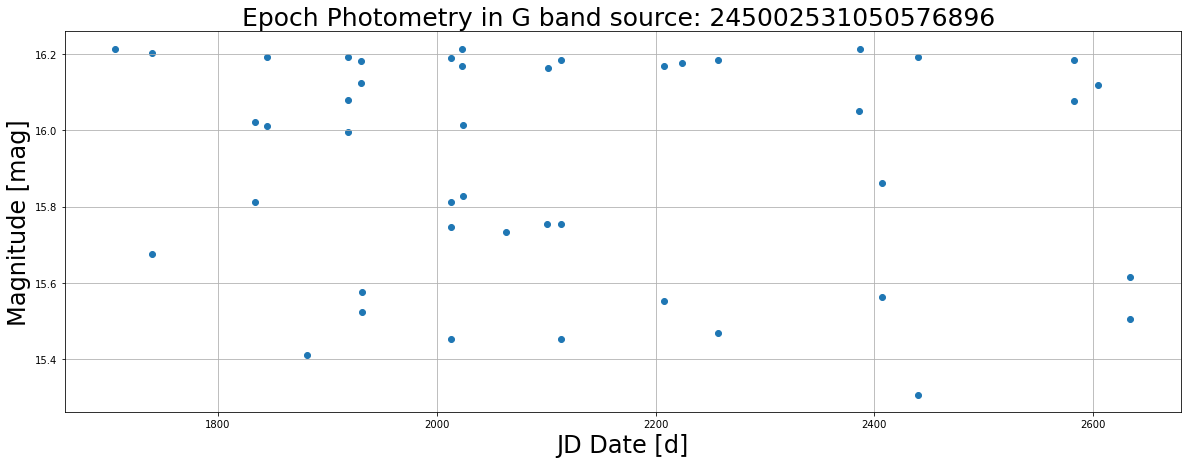

In [8]:
prod_tab.add_index('band')
t = prod_tab.loc['G']
t.sort('time')
time = np.array(t['time'])
mag = np.array(t['mag'])
source_id = t['source_id'][0]
fig = plt.figure(figsize = (20,7))
plt.grid()
plt.scatter(time, mag)
plt.title(f'Epoch Photometry in G band source: {source_id} ', size = 25)
plt.xlabel('JD Date [d]', size = 24)
plt.ylabel('Magnitude [mag]', size = 24)

## Problem 3 (lomb scargle)

Text(0.5, 1.0, 'Periodogram (souce: 245002531050576896)')

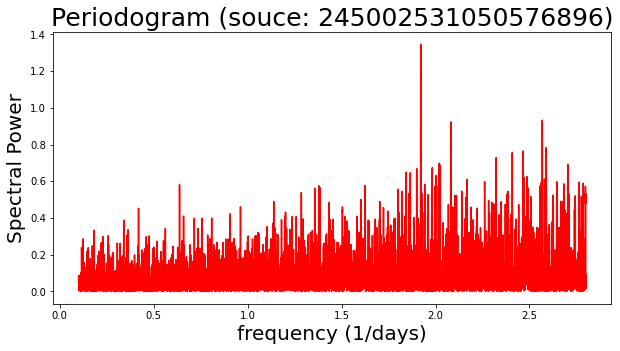

In [9]:
freq, p_ls = LombScargle(time, mag, fit_mean=False, center_data=True).autopower(minimum_frequency=0.1,
                                         maximum_frequency=2.8,
                                         normalization='psd',
                                         samples_per_peak=5)
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(freq, p_ls, 'r-')
ax.set_ylabel('Spectral Power', size = 20)
ax.set_xlabel('frequency (1/days)', size = 20)
ax.set_title(f'Periodogram (souce: {source_id})', size = 25)

## Problem 4 (Estimated mean mag and period)

In [10]:
def estimate_period(freq, p_ls):
    max_value = np.nanmax(p_ls)
    index = np.where(p_ls == max_value)[0][0]
    return 1/freq[index]

def get_lomb_scargle(time, mag):
    freq, p_ls = LombScargle(time, mag, fit_mean=False, center_data=True).autopower(minimum_frequency=0,
                                         maximum_frequency=3,
                                         normalization='psd',
                                         samples_per_peak=5)
    return freq, p_ls

def get_time_mag(dl_key):
    product  = datalink[dl_key][0]
    prod_tab = product.to_table()
    prod_tab.add_index('band')
    t = prod_tab.loc['G']
    t.sort('time')
    time = np.array(t['time'])
    mag = np.array(t['mag'])
        
    return time, mag

def get_period(dl_key):
    time, mag = get_time_mag(dl_key)
    freq, p_ls = get_lomb_scargle(time, mag)
    
    return estimate_period(freq, p_ls)

def estimate_mean_mag(dl_key):
    product  = datalink[dl_key][0]
    prod_tab = product.to_table()
    prod_tab.add_index('band')
    t = prod_tab.loc['G']
    t.sort('time')
    mag = np.array(t['mag'])
    
    converted_mag = []
    for i in range(len(mag)):
        converted_mag.append(10**(mag[i]/(-2.5)))
    
    return (-2.5)*np.log10(np.mean(converted_mag))

def get_source_id(dl_key):
    product  = datalink[dl_key][0]
    prod_tab = product.to_table()
    prod_tab.add_index('band')
    t = prod_tab.loc['G']
    t.sort('time')
    source_id = t['source_id'][0]
    return source_id
    
def plot_epoch_phot(dl_key):
    product  = datalink[dl_key][0]
    prod_tab = product.to_table()

    prod_tab.add_index('band')
    t = prod_tab.loc['G']
    t.sort('time')
    time = np.array(t['time'])
    mag = np.array(t['mag'])
    source_id = t['source_id'][0]
    fig = plt.figure(figsize = (20,7))
    plt.grid()
    plt.scatter(time, mag)
    plt.title(f'Epoch Photometry in G band, Source ID: {source_id} ', size = 25)
    plt.xlabel('JD Date [d]', size = 23)
    plt.ylabel('Magnitude [mag]', size = 23)
    
def plot_lomb_scargle(dl_key):
    time, mag = get_time_mag(dl_key)
    freq, p_ls = LombScargle(time, mag, fit_mean=False, center_data=True).autopower(minimum_frequency=0.1,
                                         maximum_frequency=2.8,
                                         normalization='psd',
                                         samples_per_peak=5)
    fig, ax = plt.subplots(1, figsize=(10, 5))
    source_id = get_source_id(dl_key)
    ax.plot(freq, p_ls, 'r-')
    ax.set_ylabel('Spectral Power', size = 20)
    ax.set_xlabel('frequency (1/days)', size = 20)
    ax.set_title(f'Periodogram, Source ID: {source_id})', size = 25)
    

def plot_phase_phot(dl_key):
    product  = datalink[dl_key][0]
    prod_tab = product.to_table()
    prod_tab.add_index('band')
    t = prod_tab.loc['G']
    t.sort('time')
    time = np.array(t['time'])
    mag = np.array(t['mag'])
    source_id = t['source_id'][0]
    fig = plt.figure(figsize = (20,7))
    period = get_period(dl_key)
    plt.grid()
    plt.scatter(time%period, mag, label = 'phased light curve')
    plt.title(f'Phase Photometry in G band, Source ID: {source_id} ', size = 25)
    plt.xlabel('Phase [d]', size = 23)
    plt.ylabel('Magnitude [mag]', size = 23)

In [11]:
source_ids = []
estimated_mean_mags = []
estimated_periods = []

for dl_key in dl_keys:
    source_ids.append(get_source_id(dl_key))
    estimated_mean_mags.append(estimate_mean_mag(dl_key))
    estimated_periods.append(get_period(dl_key))



/srv/conda/envs/notebook/lib/python3.9/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:122: RuntimeWarning: invalid value encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS)


Text(0, 0.5, 'Residual [Days]')

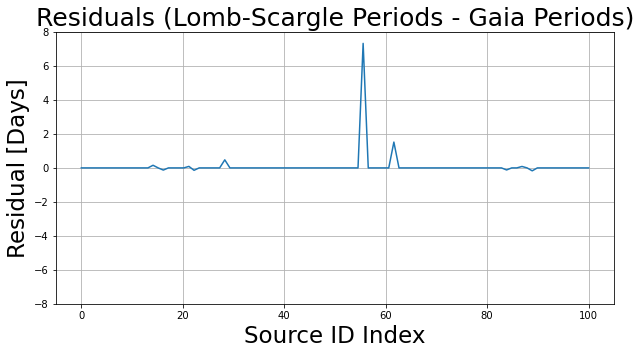

In [12]:
d = {'source_ids': source_ids, 'estimated_mean_mag': estimated_mean_mags, 'estimated_periods': estimated_periods}
df2 = pd.DataFrame(data=d)
#df2.sort_values('estimated_periods', ascending = False)
estimated_periods = df2['estimated_periods']
gaia_periods = df['pf']

residuals = df2['estimated_periods'] - df['pf']
x = np.linspace(0, len(residuals), len(residuals))
plt.figure(figsize = (10,5))
plt.plot(x, residuals)
plt.grid()
plt.ylim(-8,8)
plt.title('Residuals (Lomb-Scargle Periods - Gaia Periods)', size = 25)
plt.xlabel('Source ID Index', size = 23)
plt.ylabel('Residual [Days]', size = 23)

the estimated periods are comparable to those reported in the vari_rrlyrae catalog

## Problem 5 (fourier decomp algorithm)

In [13]:
def construct_X_matrix(T, K, P):
    X = []
    
    w = (2*np.pi)/P
    
    for t in T:
        row = []
        row.append(1)
        for k in range(K):
            row.append(np.sin((k+1)*w*t))
            row.append(np.cos((k+1)*w*t))
         
        X.append(row)
        
    return X

def least_squares(X, b):
    
    return np.linalg.lstsq(X , b, rcond=None)

def reconstructed_f(coef, t, K, P):
        
    w = (2*np.pi)/P
    X = []
    X.append(1)
    for k in range(K):
        X.append(np.sin((k+1)*w*t))
        X.append(np.cos((k+1)*w*t))
    
    return np.matmul(X, np.transpose(coef))

def plot_fourier_decomp(dl_key, k):
    time, mag = get_time_mag(dl_key)
    period = get_period(dl_key)
    plot_phase_phot(dl_key)

    b = mag
    X = construct_X_matrix(time, k, period)
    coef, residuals, rank, s = least_squares(X, b)

    t = np.linspace(0, period, 200)
    f = reconstructed_f(coef, t, k, period)

    plt.plot(t, f, label = f'K = {k}')
    plt.legend(prop={'size': 15})
    
    return f



$\beta$ is a vector of unknowns $[A_o, a_1, b_1, a_2, b_2, a_3, b_3 ...]$ with 2K+1 elements

## Problem 6 (fourier decomp of high resolution source)

period: 0.4743917357308307
mean mag: 16.1933620807742


/tmp/ipykernel_1095/1516656266.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


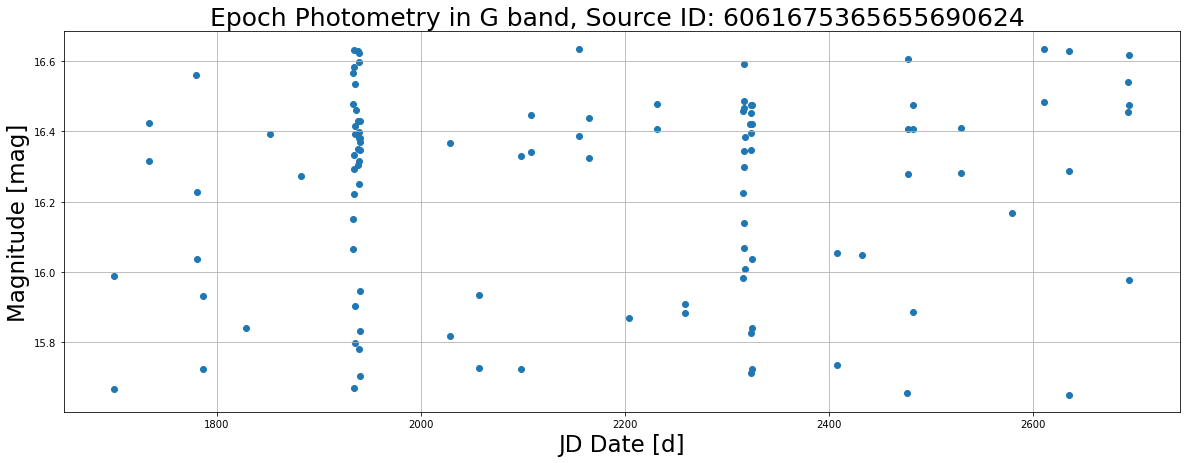

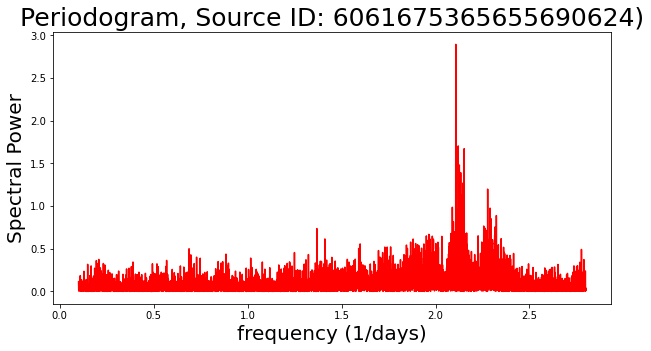

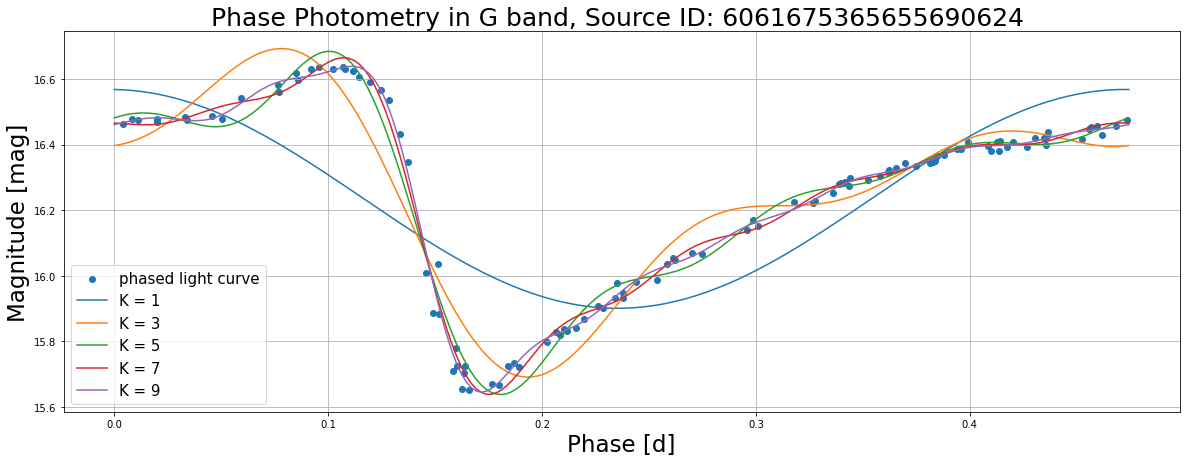

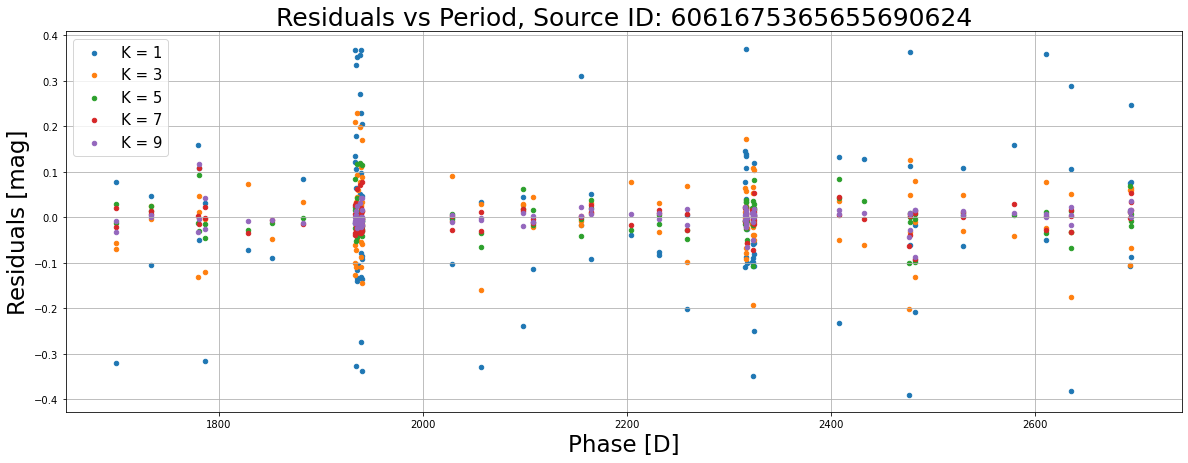

In [14]:
#find highest s/n ratio

pf = np.array(df['pf'])
pf_error = np.array(df['pf_error'])
sn_ratio = pf/pf_error
max_sn_ratio = np.nanmax(sn_ratio)
index = np.where(sn_ratio == max_sn_ratio)
index = index[0][0]
dl_key = dl_keys[index]

#initial plots

plot_epoch_phot(dl_key)
plot_lomb_scargle(dl_key)

period = get_period(dl_key)
estimate_mean_mag(dl_key)
source_id = get_source_id(dl_key)
print('period:',period)
print('mean mag:',estimate_mean_mag(dl_key))

#series representations

time, mag = get_time_mag(dl_key)
plot_phase_phot(dl_key)

b = mag
K = [1,3,5,7,9]
for k in K:
    X = construct_X_matrix(time, k, period)
    coef, residuals, rank, s = least_squares(X, b)

    t = np.linspace(0, period, 200)
    f = reconstructed_f(coef, t, k, period)

    plt.plot(t, f, label = f'K = {k}')
plt.legend(prop={'size': 15})

#plot residuals 
plt.figure(figsize = (20,7))

for k in K:
    X = construct_X_matrix(time, k, period)
    coef, residuals, rank, s = least_squares(X, b)

    f = reconstructed_f(coef, time, k, period)
    
    
    plt.scatter(time,mag - f, label = f'K = {k}', s = 20)

plt.title(f'Residuals vs Period, Source ID: {source_id}', size = 25)
plt.grid()
plt.xlabel('Phase [D]', size = 23)
plt.ylabel('Residuals [mag]', size = 23)
plt.legend(prop={'size': 15})



## Problem 7 (chi^2 for K) 

/tmp/ipykernel_1095/1516656266.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


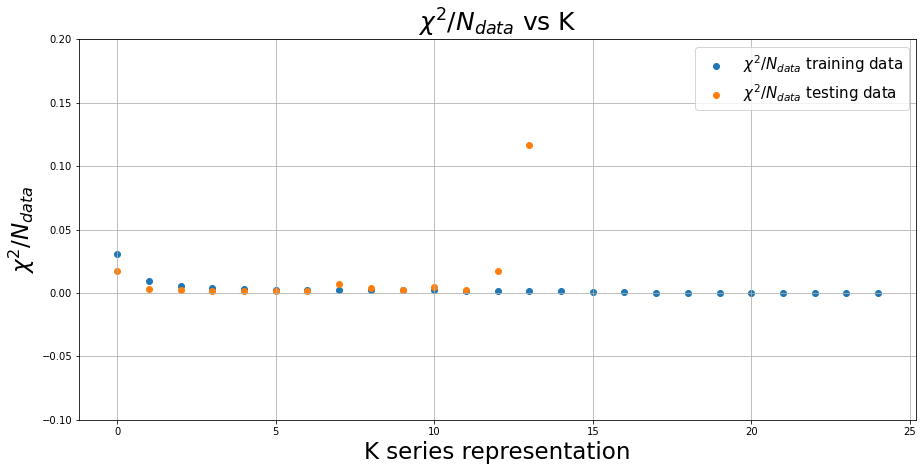

In [15]:

dl_key = dl_keys[33]
period = get_period(dl_key)

#split data into training and test

time, mag = get_time_mag(dl_key)

time_train, time_test, mag_train, mag_test = train_test_split(time, mag, train_size = 0.8, random_state = 42)

b = mag_train
K = [x for x in range(25)]
chi2s_train = []
chi2s_test = []
for k in K:
    X = construct_X_matrix(time_train, k, period)
    coef, residuals, rank, s = least_squares(X, b)
    
    #training
    f_train = reconstructed_f(coef, time_train, k, period)
    chi2_train = np.sum((mag_train-f_train)**2) / len(time_train)
    chi2s_train.append(chi2_train)
    
    #testing
    f_test = reconstructed_f(coef, time_test, k, period)
    chi2_test = np.sum((mag_test-f_test)**2) / len(time_test)
    chi2s_test.append(chi2_test)
    
plt.figure(figsize = (15,7))
plt.scatter(K, chi2s_train, label = '$\chi^2 / N_{data}$ training data')
plt.scatter(K, chi2s_test, label = '$\chi^2 / N_{data}$ testing data')
plt.grid()
plt.title('$\chi^2 / N_{data}$ vs K',size = 25)
plt.xlabel('K series representation',size = 23)
plt.ylabel('$\chi^2 / N_{data}$',size = 23)
plt.ylim(-0.1,0.2)
plt.legend(prop={'size': 15})


## Problem 8 (light curve extrapolation)

/tmp/ipykernel_1095/1516656266.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


(2634.0, 2640.0)

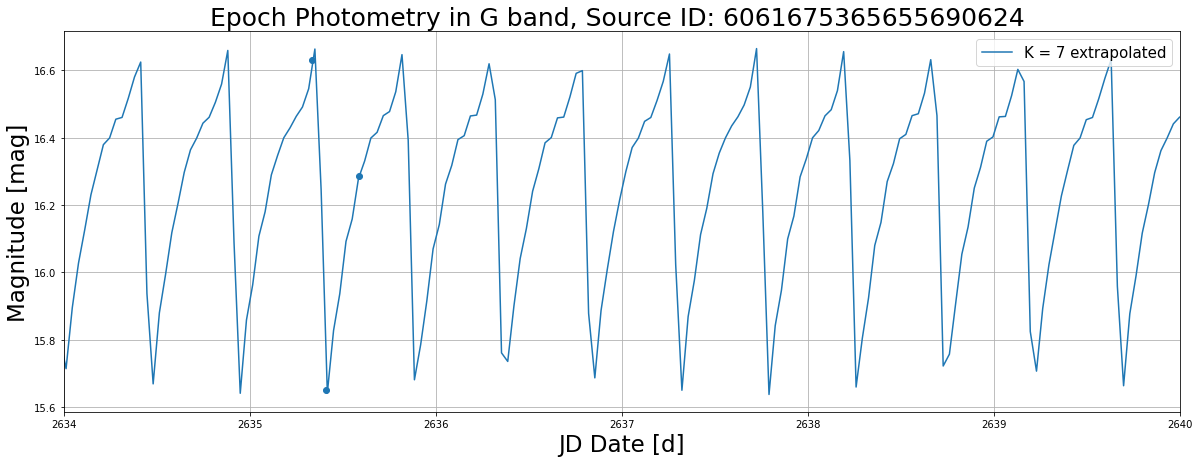

In [16]:
#extrapolation
dl_key = dl_keys[index]
period = get_period(dl_key)

time, mag = get_time_mag(dl_key)
plot_epoch_phot(dl_key)

b = mag
k = 7

X = construct_X_matrix(time, k, period)
coef, residuals, rank, s = least_squares(X, b)

t = np.linspace(2630, 2640, 300)
f = reconstructed_f(coef, t, k, period)
plt.plot(t, f, label = f'K = {k} extrapolated')
plt.legend(prop={'size': 15})
plt.xlim(2634, 2640)


## Problem 9 (Accurate Mean Mag from fourier decomp)

In [17]:
def fourier_decomp(dl_key, k, samples = 200):
    time, mag = get_time_mag(dl_key)
    period = get_period(dl_key)
    b = mag
    
    X = construct_X_matrix(time, k, period)
    coef, residuals, rank, s = least_squares(X, b)

    t = np.linspace(0, period, samples)
    f = reconstructed_f(coef, t, k, period)
    return f
    
def get_fourier_mean_mag(f):
    converted_mag = []
    for i in range(len(f)):
        converted_mag.append(10**(f[i]/(-2.5)))
        
    return (-2.5)*np.log10(np.mean(converted_mag))

def get_absolute_mag(dl_key, d):
    f = fourier_decomp(dl_key , 7)
    m = get_fourier_mean_mag(f)   
    
    M = m - 5*np.log10(d) + 5
    return M


In [18]:
source_ids = []
fourier_mean_mags = []
k = 7

for dl_key in dl_keys:
    source_ids.append(get_source_id(dl_key))
    f = fourier_decomp(dl_key, k, samples = 200)
    fourier_mean_mag = get_fourier_mean_mag(f)
    
    fourier_mean_mags.append(fourier_mean_mag)

d = {'source_ids': source_ids, 'fourier_mean_mag': fourier_mean_mags}
df3 = pd.DataFrame(data=d)
#df2.sort_values('estimated_periods', ascending = False)
df3

/tmp/ipykernel_1095/1516656266.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


source_ids  fourier_mean_mag
0    245002531050576896         15.857052
1    245504251951140864         17.990431
2    245823861938360064         19.337150
3    246756973652292992         12.355293
4    359112665277840512         15.905017
..                  ...               ...
95  2195648132814029312         19.068327
96  2195750146876812032         19.203695
97  2195878209919982464         17.621507
98  2195880752540525952         16.563064
99  2195937888486787840         18.360417

[100 rows x 2 columns]

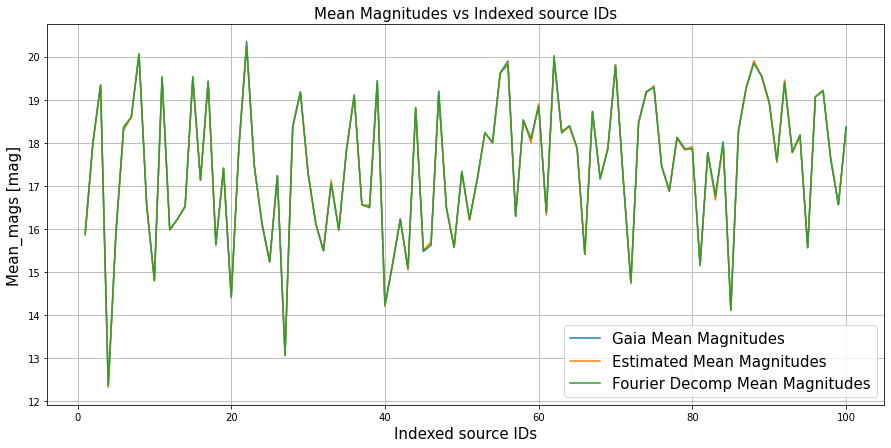

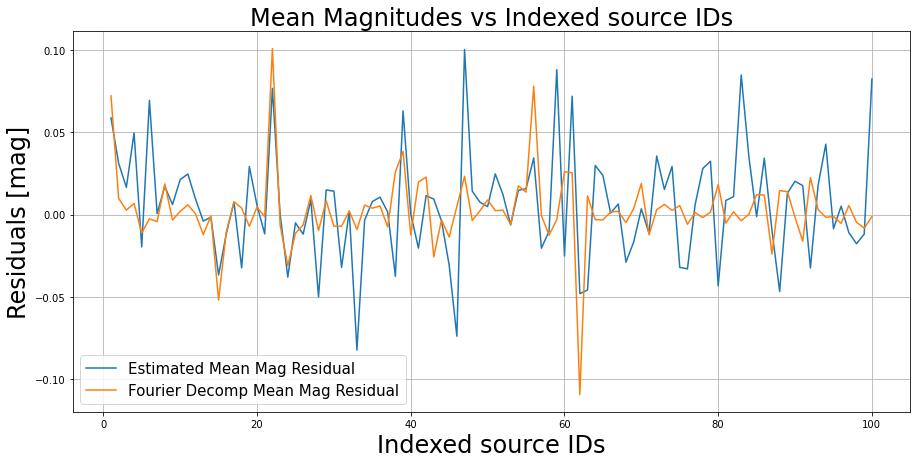

In [19]:
# plot comparisons 

gaia_mean_mags = df['int_average_g']

plt.figure(figsize = (15, 7))
x = np.linspace(1,100, 100)
plt.plot(x, gaia_mean_mags, label = 'Gaia Mean Magnitudes')
plt.plot(x, estimated_mean_mags, label = 'Estimated Mean Magnitudes')
plt.plot(x, fourier_mean_mags, label = 'Fourier Decomp Mean Magnitudes')
plt.grid()
plt.xlabel('Indexed source IDs', size = 15)
plt.ylabel('Mean_mags [mag]', size = 15)
plt.title('Mean Magnitudes vs Indexed source IDs', size = 15)
plt.legend(prop={'size': 15})

#plot residuals
plt.figure(figsize = (15, 7))
plt.plot(x, gaia_mean_mags - estimated_mean_mags, label = 'Estimated Mean Mag Residual')
plt.plot(x, gaia_mean_mags - fourier_mean_mags, label = 'Fourier Decomp Mean Mag Residual')
plt.grid()
plt.xlabel('Indexed source IDs', size = 24)
plt.ylabel('Residuals [mag]', size = 24)
plt.title('Mean Magnitudes vs Indexed source IDs', size = 24)
plt.legend(prop={'size': 15})

The residuals are smaller for most sources but there are still peaks that follow the estimated means from the raw data, indicating that our data is giving limited results in which our fourier decomposition is being affected

## Problem 10 (RRc  and RRab comparison)

In [20]:
#query gaia database for RRc

query_RRc = """SELECT TOP 3
*

FROM gaiadr3.vari_rrlyrae 

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 80
AND gaiadr3.vari_rrlyrae.int_average_g >= 15
AND best_classification = 'RRc'

"""

@memory.cache
def get_gaia_query(q):
    start = TIME.time()
    job = Gaia.launch_job(q)
    print(f"Total time: {TIME.time()-start:0.2f} sec")
    return job.get_results()

df_RRc = get_gaia_query(query_RRc)

/srv/conda/envs/notebook/lib/python3.9/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:122: RuntimeWarning: invalid value encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS)
/tmp/ipykernel_1095/1516656266.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


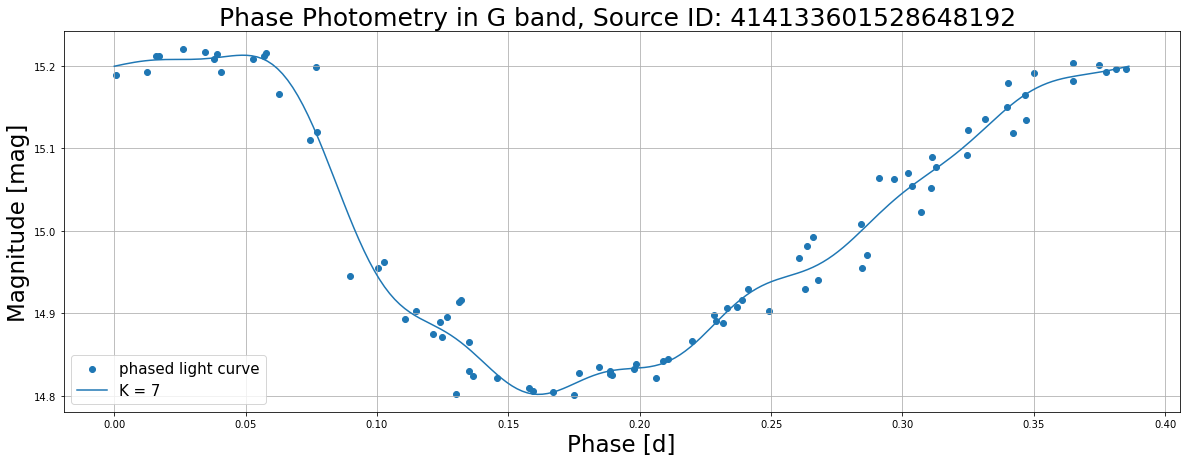

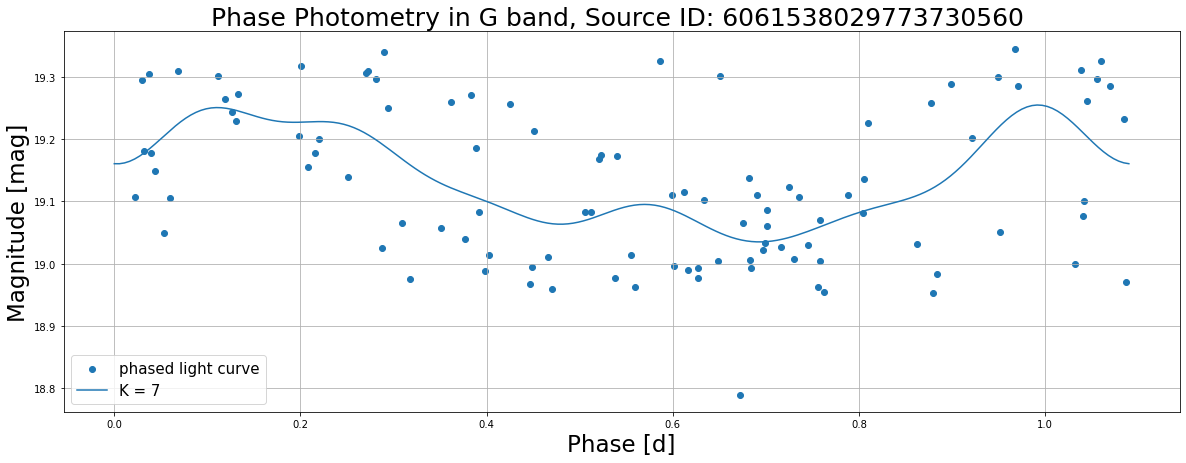

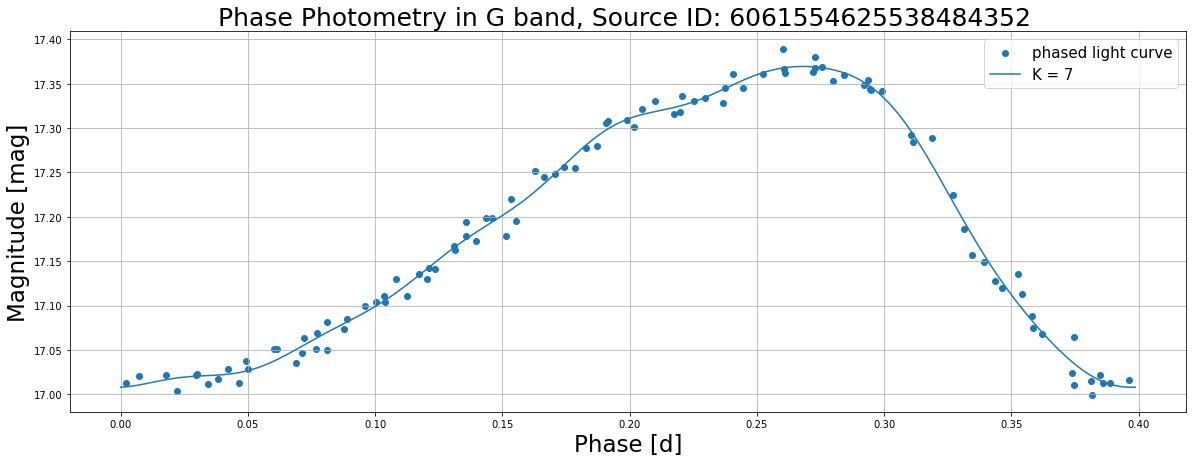

In [21]:
#get light curves of RRc

retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'INDIVIDUAL'
data_release = 'Gaia DR3'

datalink = Gaia.load_data(ids=df_RRc['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
dl_keys_RRc  = [inp for inp in datalink.keys()]

dl_keys_RRc

#plot phase and fourier decomp

for dl_key in dl_keys_RRc:
    plot_fourier_decomp(dl_key, 7)
    
#STREAMLINE

In [22]:
#query gaia database for RRab
query_RRab = """SELECT TOP 3
*

FROM gaiadr3.vari_rrlyrae 

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 80
AND gaiadr3.vari_rrlyrae.int_average_g >= 15
AND best_classification = 'RRab'

"""
@memory.cache
def get_gaia_query(q):
    start = TIME.time()
    job = Gaia.launch_job(q)
    print(f"Total time: {TIME.time()-start:0.2f} sec")
    return job.get_results()

df_RRab = get_gaia_query(query_RRab)

/tmp/ipykernel_1095/1516656266.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


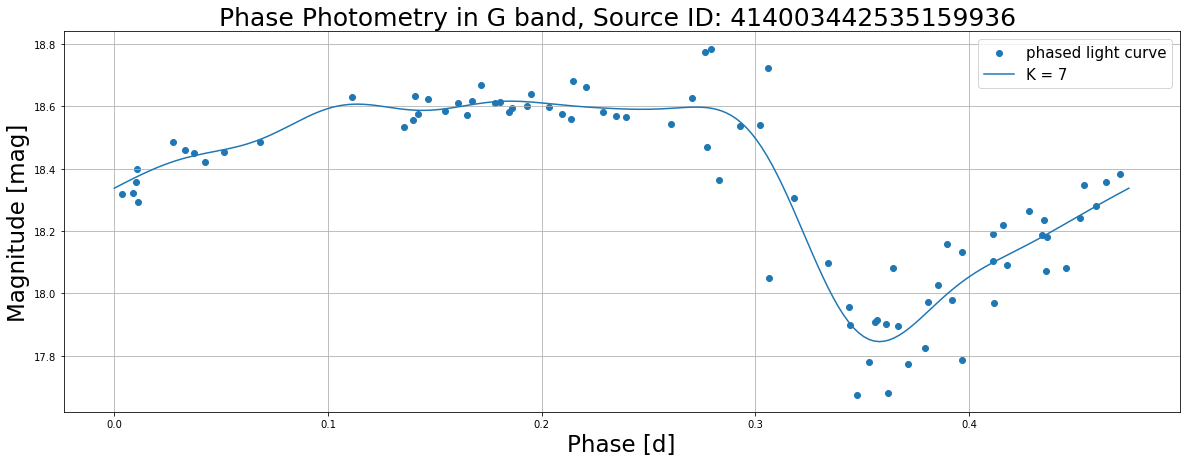

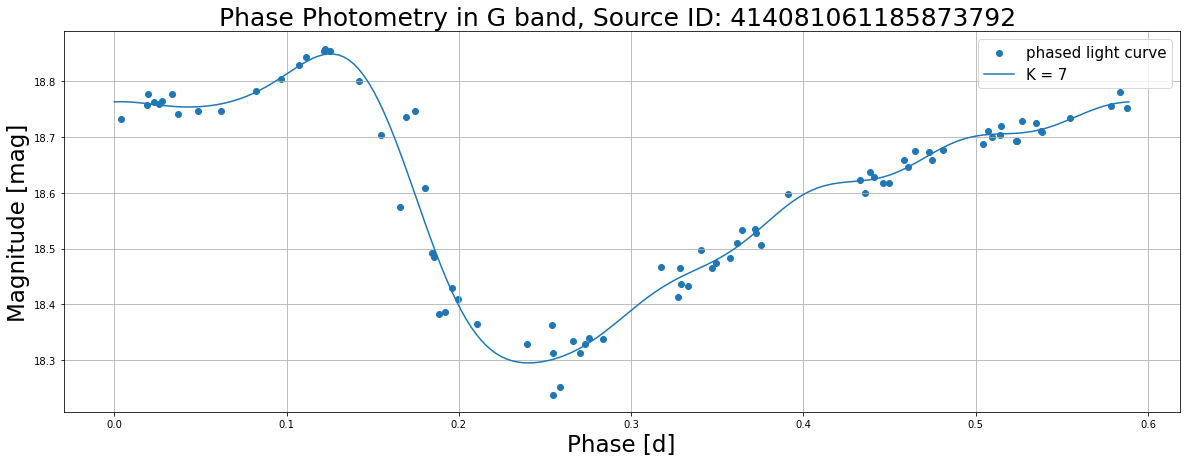

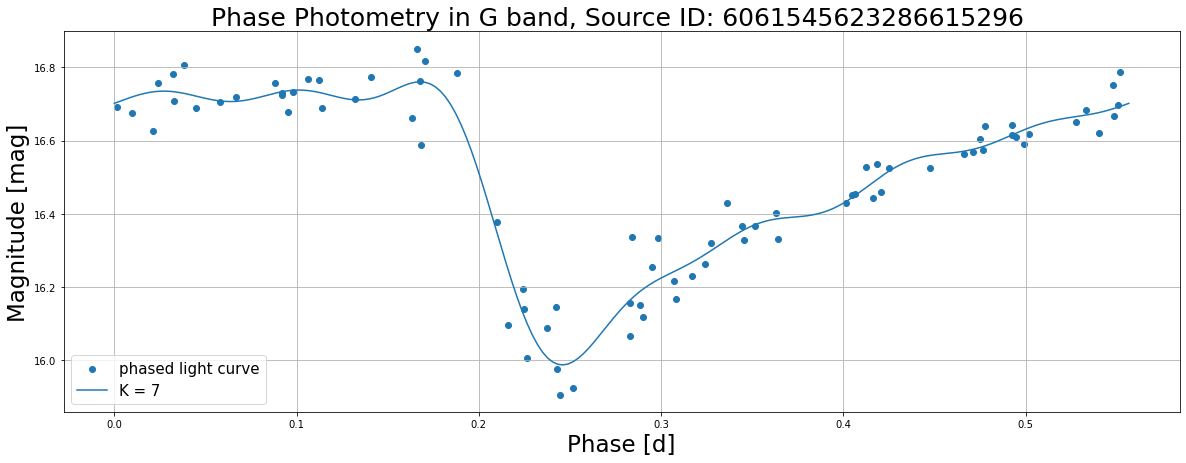

In [23]:
#get light curves of RRab

retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'INDIVIDUAL'
data_release = 'Gaia DR3'

datalink = Gaia.load_data(ids=df_RRab['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
dl_keys_RRab  = [inp for inp in datalink.keys()]

dl_keys_RRab

#plot phase and fourier decomp

for dl_key in dl_keys_RRab:
    plot_fourier_decomp(dl_key, 7)
    
#STREAMLINE

The RRab class of RR Lyrae stars have a characteristic sharp dip in magnitude in which it quickly rises again, with a negative concavity. The RRc class has a similar sharp magnitude dip, but the way in which it rises appears to be slower, having positive concavity.

http://ogle.astrouw.edu.pl/atlas/RR_Lyr.html

## Problem 11 (Blazhko effect)

There is a significant intrinsic scatter in the phase plot of the second RRc source. RRc stars exhibit changes in pulsation periods. (First overtone pulsators)

Netzel et al. 2018: https://arxiv.org/pdf/1812.05409.pdf
- 'Blazhko effect is quasi-periodic modulation of am- plitude and/or phase of a subgroup of RR Lyrae stars'

## Problem 12 (new query outside disk)

In [24]:
#new query
querydr2 = """SELECT 500
gaia_source.source_id,
gaia_source.parallax,
gaia_source.parallax_over_error,
gaia_source.b,

vari_rrlyrae.pf,
vari_rrlyrae.pf_error,
vari_rrlyrae.int_average_g,
vari_rrlyrae.int_average_g_error

FROM gaiadr3.vari_rrlyrae 
JOIN gaiaedr3.gaia_source USING (source_id)

JOIN gaiaedr3.dr2_neighborhood AS dr3xdr2
ON dr3xdr2.dr3_source_id = gaia_source.source_id 

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 40
AND ABS(gaia_source.b) > 30
AND gaia_source.parallax > 0.25


AND pf IS NOT NULL 


"""

'JOIN gaiaedr3.gaia_source USING (source_id)'


query = """SELECT TOP 500
gaia_source.source_id,
gaia_source.parallax,
gaia_source.parallax_over_error,
gaia_source.b,

vari_rrlyrae.pf,
vari_rrlyrae.pf_error,
vari_rrlyrae.int_average_g,
vari_rrlyrae.int_average_g_error

FROM gaiadr3.vari_rrlyrae 
JOIN gaiaedr3.gaia_source USING (source_id) 

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 40
AND ABS(gaia_source.b) > 30
AND gaia_source.parallax > 0.25


AND pf IS NOT NULL 


"""


@memory.cache
def get_gaia_query(q):
    start = TIME.time()
    job = Gaia.launch_job(q)
    print(f"Total time: {TIME.time()-start:0.2f} sec")
    return job.get_results()

df = get_gaia_query(query)
df

<Table length=500>
     source_id            parallax      ... int_average_g int_average_g_error
                            mas         ...      mag              mag        
       int64              float64       ...    float32          float32      
------------------- ------------------- ... ------------- -------------------
5082275006547809536 0.26809523957285347 ...     13.462838         0.003699631
5083238071357950336  0.3829277675273604 ...     19.604332         0.006446325
5083946363004134144  0.5946781130908292 ...     12.052523        0.0041959034
5094203642556959744  0.5017024595959433 ...     11.987591        0.0063922284
5094426804761045248  0.4086511433886336 ...     12.443733         0.010910096
5098240155900394112 0.36106562106170625 ...     12.518427          0.01379541
4658071252932747008  0.2983910008107831 ...     19.227907         0.019217765
4658085821547585024  1.0071331974362467 ...     19.038399          0.03759266
4658086508742288896  0.3511608774998638 ...      19.48808         0.020617655
                ...                 ... ...           ...                 ...
4659911015072019584 0.27365429618423043 ...      19.63614        0.0026140332
4659911358669432576 0.31448023402266184 ...     19.393433         0.001911359
4659921662261575936 0.46501723716969534 ...     19.186335         0.015032472
4659926403912856320  0.2768357352066926 ...     19.074127        0.0033939392
4659935788407126912 0.26272345985038553 ...     19.117308        0.0018445399
4659969800272027264   0.341081982884122 ...     19.040012         0.002768081
4659984678017953792 0.29492299031364716 ...     18.886377        0.0047278833
4660033400127958528  0.2571737798240434 ...     19.215754        0.0035729837
4660055154157378560  0.5573989180524423 ...     19.039564         0.009807689
4660079583926900992 0.39346138240299755 ...     19.399242         0.017324384

Source IDs might change between the dr2 and dr3 catalog when there is a misidentification of sources at one location, for example two sources being interpreted as one or the other way around. Torra et al., 2020 https://arxiv.org/abs/2012.06420

## Problem 13 (Bailer Jones Distances)

Bailer-Jones et al, 2020: https://arxiv.org/pdf/2012.05220.pdf

In [25]:
#new query
query = """SELECT TOP 500
gaia_source.source_id,
gaia_source.parallax,
gaia_source.parallax_over_error,
gaia_source.b,
gaia_source.l,

vari_rrlyrae.pf,
vari_rrlyrae.pf_error,
vari_rrlyrae.int_average_g,
vari_rrlyrae.int_average_g_error,

gaiaedr3_distance.r_med_geo,
gaiaedr3_distance.r_hi_geo,
gaiaedr3_distance.r_lo_geo

FROM gaiadr3.vari_rrlyrae 
JOIN gaiaedr3.gaia_source USING (source_id)
JOIN external.gaiaedr3_distance USING (source_id)

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 40
AND ABS(gaia_source.b) > 30
AND gaia_source.parallax > 0.25
AND gaia_source.parallax_over_error > 10


AND pf IS NOT NULL 


"""
'''JOIN external.gaiaedr3_distance USING (source_id)
gaiaedr3_distance.r_med_geo
gaiaedr3_distance.r_hi_geo
gaiaedr3_distance.r_hi_geo
'''

@memory.cache
def get_gaia_query(q):
    start = TIME.time()
    job = Gaia.launch_job(q)
    print(f"Total time: {TIME.time()-start:0.2f} sec")
    return job.get_results()

df = get_gaia_query(query)
df

<Table length=375>
     source_id            parallax      ...  r_hi_geo  r_lo_geo
                            mas         ...     pc        pc   
       int64              float64       ...  float32   float32 
------------------- ------------------- ... --------- ---------
5082275006547809536 0.26809523957285347 ... 3426.7776 3081.9224
5083946363004134144  0.5946781130908292 ... 1652.5009 1558.1212
5094203642556959744  0.5017024595959433 ... 1978.6187 1809.5858
5094426804761045248  0.4086511433886336 ... 2390.4333 2213.6853
5098240155900394112 0.36106562106170625 ...  2714.123 2500.5015
 584371601026374272  0.5023216203946383 ... 1942.4014 1837.6722
 586254622063844736   0.413362843606383 ... 2378.0483 2172.1985
3844396540563624832   0.613325049466868 ... 1566.2969  1467.515
2313783205448950784  0.3701002230002173 ... 2653.8633 2404.7957
                ...                 ... ...       ...       ...
4972298520643889536 0.25685346932492525 ... 3580.3494 3207.4067
4982010850448460160 0.29846906523214584 ... 3086.0085  2863.752
4984655725669340544 0.37781206603604417 ... 2599.2515 2399.0757
4985455998336183168  0.8790500477619054 ... 1161.5187 1069.5754
3675137235252376960  0.5023581581779739 ...  1938.512 1826.1979
 632467228922479104  0.2755567391321881 ...  3473.626 2875.8862
 648476397396238976 0.49866765663757956 ... 1938.1553 1789.4633
3727833391597367424  0.7722731001961485 ... 1263.0288   1200.33
3731723090075245696  0.5577167596167709 ... 1700.4858 1596.8693
3737667393532367616  0.3124025279628002 ... 3014.0408  2655.234

A posterior distribution is calculated by using a distance prior (gamma function) which has an exponentially decreases with a characteristic length scale that is direction dependent. The likelihood is an assumed Gaussian that depends on the parallax zero point. The posterior distribution is calculated numerically using MCMC. r_hi_geo - r_lo_geo represents the 68% confidence interval in which r_med_geo is the median of the distribution.  Relation between parallax and distance requires a non linear transfromation. As parallax measurements are smaller, the errors on distances become large.

## Problem 14 (Bailer Jones vs EDR3 Parallax) 

Text(0.5, 1.0, 'Location of Sources in Galactic Coordinates')

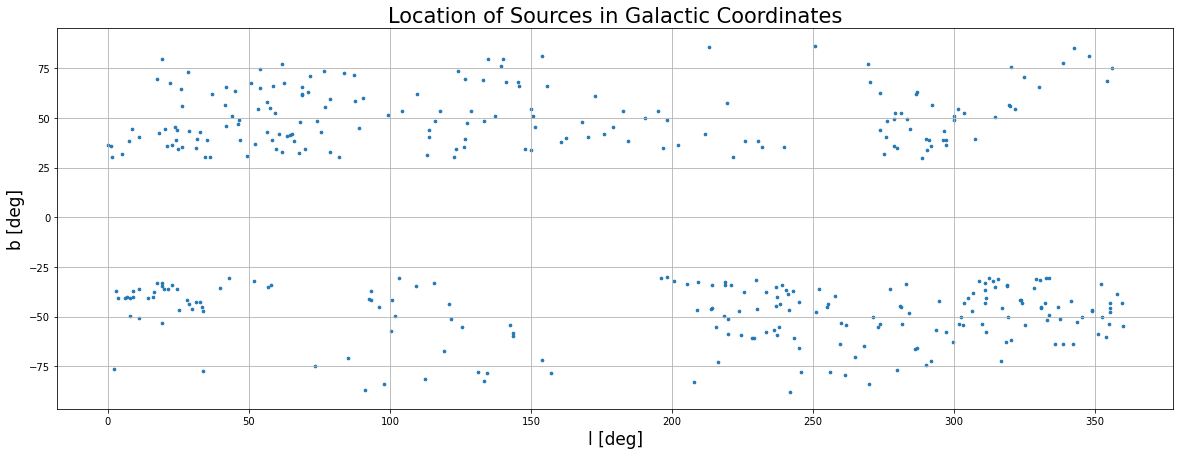

In [26]:
bs = df['b']
ls = df['l']

plt.figure(figsize = (20,7))
plt.scatter(ls, bs, s = 7)
plt.grid()
plt.xlabel('l [deg]', size = 17)
plt.ylabel('b [deg]', size = 17)
plt.title('Location of Sources in Galactic Coordinates', size = 21)

(0.0, 5000.0)

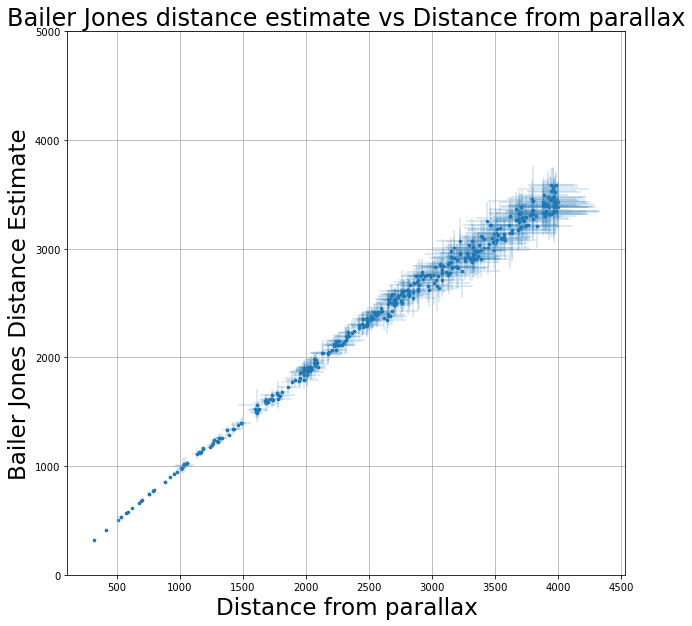

In [27]:
#plot distance estimate and parallax 
r_med_geos = df['r_med_geo']
parallaxes = df['parallax']
parallax_distances = 1/parallaxes * 1000
parallax_over_errors = df['parallax_over_error']
parallax_errors = 1/parallax_over_errors * parallaxes

pde = parallax_errors/parallaxes * parallax_distances

plt.figure(figsize = (10,10))
plt.grid()
plt.scatter(parallax_distances,r_med_geos,  s = 7)

bailer_jones_errors = (df['r_hi_geo'] - df['r_lo_geo'])/2

plt.errorbar(parallax_distances, r_med_geos, yerr = bailer_jones_errors, fmt = 'none', elinewidth = 0.3)
plt.errorbar(parallax_distances, r_med_geos, xerr = pde, fmt = 'none', elinewidth = 0.3)

plt.ylabel('Bailer Jones Distance Estimate', size = 23)
plt.xlabel('Distance from parallax', size = 23)
plt.title('Bailer Jones distance estimate vs Distance from parallax', size = 24)
plt.ylim(0,5000)


As the distances get larger, there is a greater discrepancy between the Bailer Jones distance and the distance calculated from parallax, indicating that the parallax uncertainties become larger.

## Problem 15 (Plot period vs G band magnitude)

In [28]:
'''retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'INDIVIDUAL'
data_release = 'Gaia DR3'

datalink = Gaia.load_data(ids=df['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
dl_keys  = [inp for inp in datalink.keys()]'''



"retrieval_type = 'EPOCH_PHOTOMETRY'\ndata_structure = 'INDIVIDUAL'\ndata_release = 'Gaia DR3'\n\ndatalink = Gaia.load_data(ids=df['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)\ndl_keys  = [inp for inp in datalink.keys()]"

In [29]:
'''periods = []
G_band_absolute_magnitudes = []
for dl_key in dl_keys:
    periods.append(get_period(dl_key))
    source_id = get_source_id(dl_key)
    
    df.add_index('source_id')
    t = df.loc[source_id]
    d = t['r_med_geo']
    
    absolute_mags = get_absolute_mag(dl_key, d)
    G_band_absolute_magnitudes.append(absolute_mags)'''



"periods = []\nG_band_absolute_magnitudes = []\nfor dl_key in dl_keys:\n    periods.append(get_period(dl_key))\n    source_id = get_source_id(dl_key)\n    \n    df.add_index('source_id')\n    t = df.loc[source_id]\n    d = t['r_med_geo']\n    \n    absolute_mags = get_absolute_mag(dl_key, d)\n    G_band_absolute_magnitudes.append(absolute_mags)"

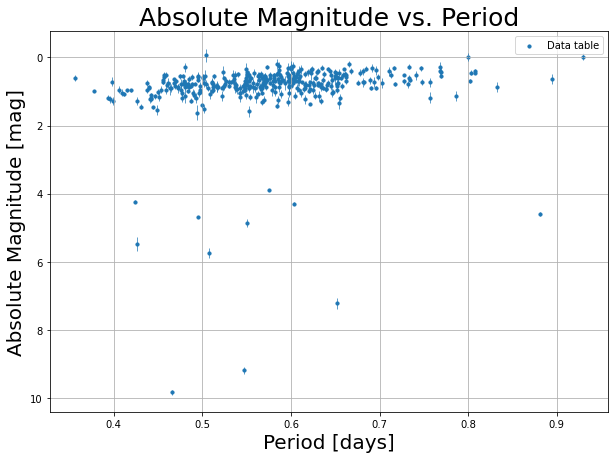

In [30]:
plt.figure(figsize = (10,7))
bailer_jones_d = df['r_med_geo']
errors_d = (df['r_hi_geo'] - df['r_lo_geo'])/2
errors_m = 5 * (1/np.log(10)) * errors_d / bailer_jones_d

'''plt.scatter(periods, G_band_absolute_magnitudes, s = 5, label = 'calculated mean mags + calculated periods')
plt.errorbar(periods, G_band_absolute_magnitudes, yerr = errors_m, fmt = 'none', elinewidth = 0.7)
'''
periods_df = df['pf']
magnitudes_df = df['int_average_g'] 
M = magnitudes_df - 5*np.log10(bailer_jones_d) + 5
plt.scatter(periods_df, M, s = 10, label = 'Data table')
plt.errorbar(periods_df, M, yerr = errors_m, fmt = 'none', elinewidth = 0.7)

plt.legend()
plt.grid()
plt.xlabel('Period [days]', size = 20)
plt.ylabel('Absolute Magnitude [mag]', size = 20)
plt.title('Absolute Magnitude vs. Period', size = 25)
plt.gca().invert_yaxis()


## Problem 16 (quality cuts)

In [31]:
#new query
query = """SELECT TOP 500
gaia_source.source_id,
gaia_source.parallax,
gaia_source.parallax_over_error,
gaia_source.b,
gaia_source.l,

vari_rrlyrae.pf,
vari_rrlyrae.pf_error,
vari_rrlyrae.int_average_g,
vari_rrlyrae.int_average_g_error,

gaiaedr3_distance.r_med_geo,
gaiaedr3_distance.r_hi_geo,
gaiaedr3_distance.r_lo_geo

FROM gaiadr3.vari_rrlyrae 
JOIN gaiaedr3.gaia_source USING (source_id)
JOIN external.gaiaedr3_distance USING (source_id)

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 40
AND ABS(gaia_source.b) > 30
AND gaia_source.parallax > 0.25
AND gaia_source.parallax_over_error > 10 

AND gaia_source.astrometric_excess_noise < 1
AND gaia_source.phot_bp_rp_excess_factor < 1.3 + 0.06 * POWER(gaia_source.bp_rp, 2)
AND gaia_source.phot_bp_rp_excess_factor > 1.0 + 0.015 * POWER(gaia_source.bp_rp, 2)

AND pf IS NOT NULL 


"""

'AND SQRT(gaia_source.astrometric_chi_2_al/(astrometric_n_good_obs_al - 5)) < 1.2'
'AND 1.0 + 0.015 * POWER(gaia_source.bp_rp, 2) < gaia_source.phot_bp_rp_excess_factor < 1.3 + 0.06 * POWER(gaia_source.bp_rp, 2)'

@memory.cache
def get_gaia_query(q):
    start = TIME.time()
    job = Gaia.launch_job(q)
    print(f"Total time: {TIME.time()-start:0.2f} sec")
    return job.get_results()

df = get_gaia_query(query)


'''retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'INDIVIDUAL'
data_release = 'Gaia DR3'

datalink = Gaia.load_data(ids=df['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
dl_keys  = [inp for inp in datalink.keys()]


periods = []
G_band_absolute_magnitudes = []
for dl_key in dl_keys:
    periods.append(get_period(dl_key))
    source_id = get_source_id(dl_key)
    
    df.add_index('source_id')
    t = df.loc[source_id]
    d = t['r_med_geo']
    
    absolute_mags = get_absolute_mag(dl_key, d)
    G_band_absolute_magnitudes.append(absolute_mags)'''




"retrieval_type = 'EPOCH_PHOTOMETRY'\ndata_structure = 'INDIVIDUAL'\ndata_release = 'Gaia DR3'\n\ndatalink = Gaia.load_data(ids=df['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)\ndl_keys  = [inp for inp in datalink.keys()]\n\n\nperiods = []\nG_band_absolute_magnitudes = []\nfor dl_key in dl_keys:\n    periods.append(get_period(dl_key))\n    source_id = get_source_id(dl_key)\n    \n    df.add_index('source_id')\n    t = df.loc[source_id]\n    d = t['r_med_geo']\n    \n    absolute_mags = get_absolute_mag(dl_key, d)\n    G_band_absolute_magnitudes.append(absolute_mags)"

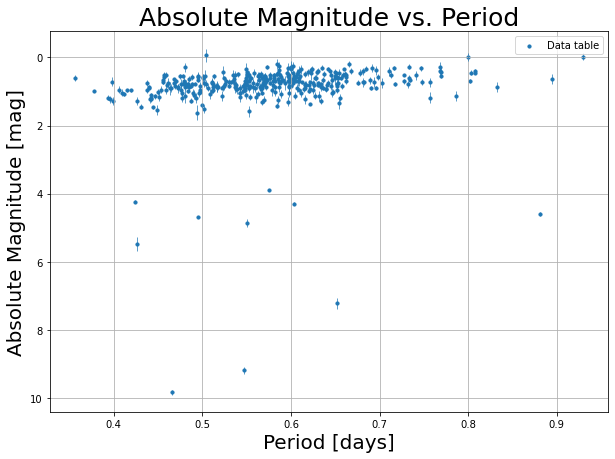

In [32]:
plt.figure(figsize = (10,7))
bailer_jones_d = df['r_med_geo']
errors_d = (df['r_hi_geo'] - df['r_lo_geo'])/2
errors_m = 5 * (1/np.log(10)) * errors_d / bailer_jones_d

'''plt.scatter(periods, G_band_absolute_magnitudes, s = 5, label = 'calculated mean mags + calculated periods')
plt.errorbar(periods, G_band_absolute_magnitudes, yerr = errors_m, fmt = 'none', elinewidth = 0.7)
'''
periods_df = df['pf']
magnitudes_df = df['int_average_g'] 
M = magnitudes_df - 5*np.log10(bailer_jones_d) + 5
plt.scatter(periods_df, M, s = 10, label = 'Data table')
plt.errorbar(periods_df, M, yerr = errors_m, fmt = 'none', elinewidth = 0.7)

plt.legend()
plt.grid()
plt.xlabel('Period [days]', size = 20)
plt.ylabel('Absolute Magnitude [mag]', size = 20)
plt.title('Absolute Magnitude vs. Period', size = 25)
plt.gca().invert_yaxis()

## Problem 17 (crude G magnitude cut) (final data)

In [33]:
#new query
query = """SELECT TOP 800
gaia_source.source_id,
gaia_source.parallax,
gaia_source.parallax_over_error,
gaia_source.b,
gaia_source.l,

vari_rrlyrae.pf,
vari_rrlyrae.pf_error,
vari_rrlyrae.int_average_g,
vari_rrlyrae.int_average_g_error,

gaiaedr3_distance.r_med_geo,
gaiaedr3_distance.r_hi_geo,
gaiaedr3_distance.r_lo_geo

FROM gaiadr3.vari_rrlyrae 
JOIN gaiaedr3.gaia_source USING (source_id)
JOIN external.gaiaedr3_distance USING (source_id)

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 40
AND ABS(gaia_source.b) > 30
AND gaia_source.parallax > 0.25
AND gaia_source.parallax_over_error > 10 

AND gaia_source.astrometric_excess_noise < 1
AND gaia_source.phot_bp_rp_excess_factor < 1.3 + 0.06 * POWER(gaia_source.bp_rp, 2)
AND gaia_source.phot_bp_rp_excess_factor > 1.0 + 0.015 * POWER(gaia_source.bp_rp, 2)
AND vari_rrlyrae.int_average_g - 5 * LOG10(gaiaedr3_distance.r_med_geo) + 5 < 3.5

AND pf IS NOT NULL 


"""

'AND SQRT(gaia_source.astrometric_chi_2_al/(astrometric_n_good_obs_al - 5)) < 1.2'
'AND 1.0 + 0.015 * POWER(gaia_source.bp_rp, 2) < gaia_source.phot_bp_rp_excess_factor < 1.3 + 0.06 * POWER(gaia_source.bp_rp, 2)'

@memory.cache
def get_gaia_query(q):
    start = TIME.time()
    job = Gaia.launch_job(q)
    print(f"Total time: {TIME.time()-start:0.2f} sec")
    return job.get_results()

df = get_gaia_query(query)
df


<Table length=364>
     source_id            parallax      ...  r_hi_geo  r_lo_geo
                            mas         ...     pc        pc   
       int64              float64       ...  float32   float32 
------------------- ------------------- ... --------- ---------
5082275006547809536 0.26809523957285347 ... 3426.7776 3081.9224
5083946363004134144  0.5946781130908292 ... 1652.5009 1558.1212
5094203642556959744  0.5017024595959433 ... 1978.6187 1809.5858
5094426804761045248  0.4086511433886336 ... 2390.4333 2213.6853
5098240155900394112 0.36106562106170625 ...  2714.123 2500.5015
 584371601026374272  0.5023216203946383 ... 1942.4014 1837.6722
 586254622063844736   0.413362843606383 ... 2378.0483 2172.1985
3844396540563624832   0.613325049466868 ... 1566.2969  1467.515
2313783205448950784  0.3701002230002173 ... 2653.8633 2404.7957
                ...                 ... ...       ...       ...
4972298520643889536 0.25685346932492525 ... 3580.3494 3207.4067
4982010850448460160 0.29846906523214584 ... 3086.0085  2863.752
4984655725669340544 0.37781206603604417 ... 2599.2515 2399.0757
4985455998336183168  0.8790500477619054 ... 1161.5187 1069.5754
3675137235252376960  0.5023581581779739 ...  1938.512 1826.1979
 632467228922479104  0.2755567391321881 ...  3473.626 2875.8862
 648476397396238976 0.49866765663757956 ... 1938.1553 1789.4633
3727833391597367424  0.7722731001961485 ... 1263.0288   1200.33
3731723090075245696  0.5577167596167709 ... 1700.4858 1596.8693
3737667393532367616  0.3124025279628002 ... 3014.0408  2655.234

In [34]:
retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'INDIVIDUAL'
data_release = 'Gaia DR3'

datalink = Gaia.load_data(ids=df['source_id'], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
dl_keys  = [inp for inp in datalink.keys()]



In [35]:
periods = []
G_band_absolute_magnitudes = []
for dl_key in dl_keys:
    periods.append(get_period(dl_key))
    source_id = get_source_id(dl_key)
    
    df.add_index('source_id')
    t = df.loc[source_id]
    d = t['r_med_geo']
    
    absolute_mags = get_absolute_mag(dl_key, d)
    G_band_absolute_magnitudes.append(absolute_mags)

/tmp/ipykernel_1095/1516656266.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


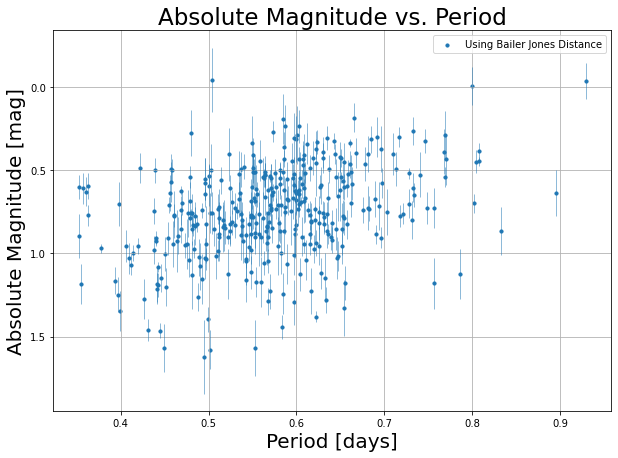

In [36]:
plt.figure(figsize = (10,7))
plt.scatter(periods, G_band_absolute_magnitudes, s = 10, label = 'Using Bailer Jones Distance')
bailer_jones_d = df['r_med_geo']
errors_d = (df['r_hi_geo'] - df['r_lo_geo'])/2
errors_m = 5 * (1/np.log(10)) * errors_d / bailer_jones_d
plt.errorbar(periods, G_band_absolute_magnitudes, yerr = errors_m, fmt = 'none', elinewidth = 0.5)

'''periods_df = df['pf']
magnitudes_df = df['int_average_g'] 
M = magnitudes_df - 5*np.log10(bailer_jones_d) + 5
plt.scatter(periods_df, M, s = 5, label = 'Data table')
'''

plt.legend()
plt.grid()
plt.xlabel('Period [days]', size = 20)
plt.ylabel('Absolute Magnitude [mag]', size = 20)
plt.title('Absolute Magnitude vs. Period', size = 23)
plt.gca().invert_yaxis()



## Problem 18 (Plot Period-absolute magnitude with parallax)

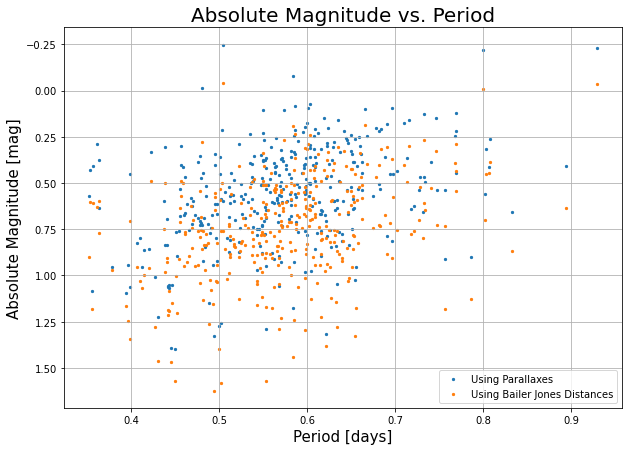

In [37]:
parallaxes = df['parallax']
distances_parallaxes = 1/parallaxes * 1000

magnitudes_df = df['int_average_g'] 
M = magnitudes_df - 5*np.log10(distances_parallaxes) + 5
plt.figure(figsize = (10,7))
plt.scatter(periods, M, s = 5, label = 'Using Parallaxes')
plt.scatter(periods, G_band_absolute_magnitudes, s = 5, label = 'Using Bailer Jones Distances')
plt.grid()
plt.xlabel('Period [days]', size = 15)
plt.ylabel('Absolute Magnitude [mag]', size = 15)
plt.title('Absolute Magnitude vs. Period', size = 20)
plt.gca().invert_yaxis()
plt.legend()


## Problem 19 i (MCMC)

In [38]:
import random

def gaussian(x, mu, sigma):
    return (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(mu - x)**2 / (2*sigma**2))

def target(x):
    mu = 1
    sigma = 0.1
    return (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(mu - x)**2 / (2*sigma**2))



steps = 10000
x = 2
xs = []
xs.append(x)

for t in range(steps):
    current_x = xs[t]
    
    proposed_x = np.random.normal(loc = current_x)

    A = target(proposed_x)/target(current_x)
    
    #print(A)
    
    probability = min(A, 1)
    
    decision = random.choices([1,0], [probability, 1-probability])
    
    
    if(decision[0] == 1):
        xs.append(proposed_x)
        
    if(decision[0] == 0):
        xs.append(current_x)
   


Text(0, 0.5, 'counts (normalized)')

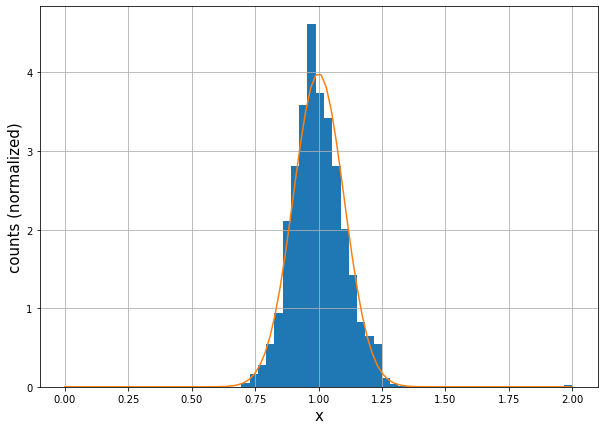

In [39]:
t = np.linspace(0, 2, 100)
y = target(t)
plt.figure(figsize = (10,7))
plt.grid()
plt.hist(xs, bins = 40, density = True)
plt.plot(t,y)
plt.xlabel('x',size = 15)
plt.ylabel('counts (normalized)', size = 15)

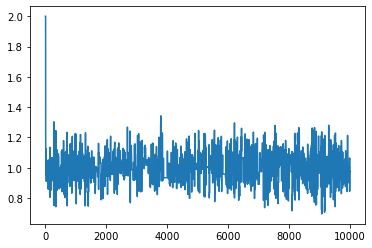

In [40]:
t = np.linspace(0, steps+1, steps+1)
plt.plot(t, xs)

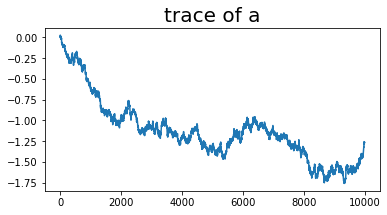

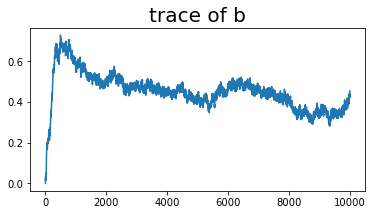

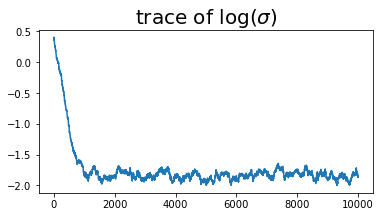

In [41]:
def model(P, a, b):
    
    return a*np.log10(P) + b

steps = 10000


def log_likelihood(a, b, sigma_log):
    
    sigma = np.exp(sigma_log)
    #sigma_list = sigma + errors_m
    sigma_list = sigma
    
    return np.sum(np.log(1/(np.sqrt(2*np.pi*((sigma_list)+data[2])**2))) + (-(data[1] - model(data[0], a, b))**2 / (2*(sigma_list + data[2])**2)))
    
data = [0,0,0]
data[0] = np.array(periods)
data[1] = np.array(G_band_absolute_magnitudes)
data[2] = np.array(errors_m)

a = 0
b = 0
sigma = 0.4

a_list = []
b_list = []
sigma_list = []

a_list.append(a)
b_list.append(b)
sigma_list.append(sigma)

for t in range(steps):
    
    #current parameters
    
    current_a = a_list[t]
    current_b = b_list[t]
    current_sigma = sigma_list[t]
    
    delta = 0.01    
    
    #generate proposal parameters
    
    proposed_a = current_a + delta*np.random.normal()
    proposed_b = current_b + delta*np.random.normal()
    proposed_sigma = current_sigma + delta*np.random.normal()

    #posterior with uniform prior
    
    proposed_posterior = log_likelihood(proposed_a, proposed_b, proposed_sigma)
    current_posterior = log_likelihood(current_a, current_b, current_sigma)
    
    
    A = np.exp(proposed_posterior - current_posterior)    
    
    probability = min(A, 1)
    
    decision = random.choices([1,0], [probability, 1-probability])
    
    if(decision[0] == 1):
        a_list.append(proposed_a)
        b_list.append(proposed_b)
        sigma_list.append(proposed_sigma)
        
    if(decision[0] == 0):
        a_list.append(current_a)
        b_list.append(current_b)
        sigma_list.append(current_sigma)
        
#get means from first round
        
a_mean = np.mean(a_list)
b_mean = np.mean(b_list)
sigma_mean = np.mean(sigma_list)

x = np.linspace(0, len(a_list), len(a_list))

plt.figure(figsize = (6,3))
plt.plot(x, a_list)
plt.title('trace of a', size = 20)
plt.figure(figsize = (6,3))
plt.plot(x, b_list)
plt.title('trace of b', size = 20)
plt.figure(figsize = (6,3))
plt.plot(x, sigma_list)
plt.title('trace of $\log(\sigma)$', size = 20)

####second round

a_list = []
b_list = []
sigma_list = []

a_list.append(a_mean)
b_list.append(b_mean)
sigma_list.append(sigma_mean)

for t in range(steps):
    
    #current parameters
    
    current_a = a_list[t]
    current_b = b_list[t]
    current_sigma = sigma_list[t]
    
    delta = 0.01
    
    #generate proposal parameters
    
    proposed_a = current_a + delta*np.random.normal()
    proposed_b = current_b + delta*np.random.normal()
    proposed_sigma = current_sigma + delta*np.random.normal()

    #posterior with uniform prior
    
    proposed_posterior = log_likelihood(proposed_a, proposed_b, proposed_sigma)
    current_posterior = log_likelihood(current_a, current_b, current_sigma)
    
    
    A = np.exp(proposed_posterior - current_posterior)    
    
    probability = min(A, 1)
    
    decision = random.choices([1,0], [probability, 1-probability])
    
    if(decision[0] == 1):
        a_list.append(proposed_a)
        b_list.append(proposed_b)
        sigma_list.append(proposed_sigma)
        
    if(decision[0] == 0):
        a_list.append(current_a)
        b_list.append(current_b)
        sigma_list.append(current_sigma)

    


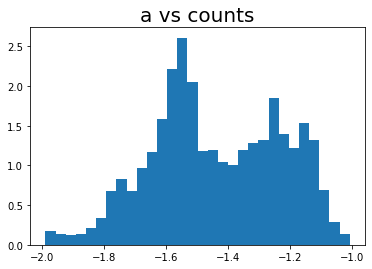

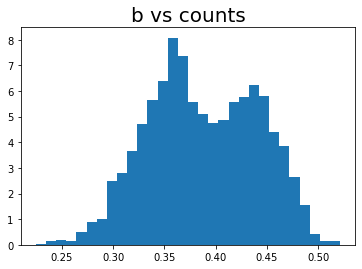

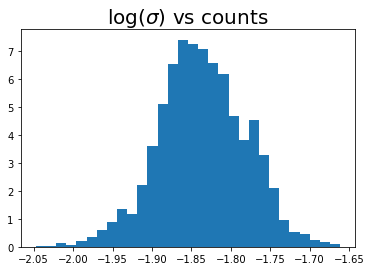

In [42]:
plt.hist(a_list, bins = 30, density = True)
plt.title('a vs counts', size = 20)
plt.figure()
plt.hist(b_list, bins = 30, density = True)
plt.title('b vs counts', size = 20)
plt.figure()
plt.hist(sigma_list, bins = 30, density = True)
plt.title('$\log(\sigma)$ vs counts', size = 20)
plt.show()

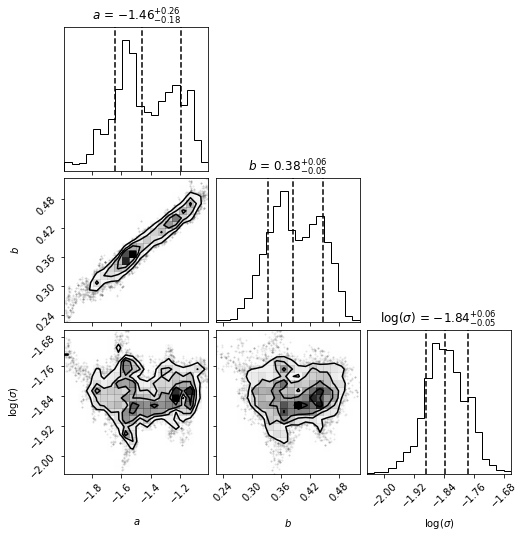

In [43]:
import corner

samples = np.vstack(np.transpose([a_list, b_list, sigma_list]))
figure = corner.corner(samples, labels = [r'$a$', r'$b$', r'log($\sigma$)'], quantiles=[0.16, 0.5, 0.84], show_titles=True)

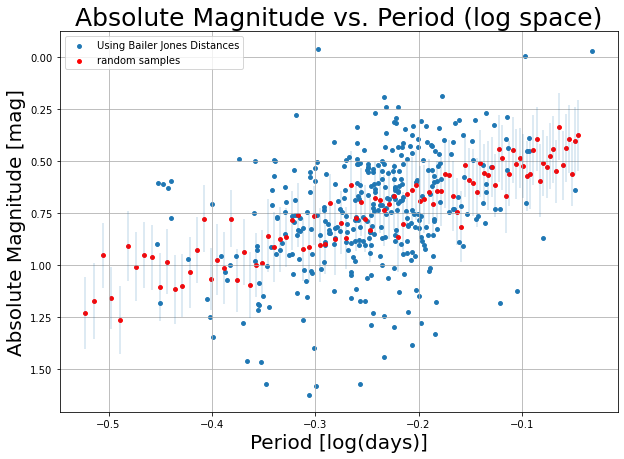

In [44]:
apick = []
bpick = []
sigmapick = []
P = np.linspace(0.3,0.9, 100)
for i in range(100):
    apick.append(random.choice(a_list))
    bpick.append(random.choice(b_list))
    sigmapick.append(random.choice(np.exp(sigma_list)))
    

M = apick*np.log10(P) + bpick  
    
    
plt.figure(figsize = (10,7))
plt.scatter(np.log10(periods), G_band_absolute_magnitudes, s = 15, label = 'Using Bailer Jones Distances')
plt.scatter(np.log10(P), M, s = 15, color = 'r', label = 'random samples')
plt.errorbar(np.log10(P), M, yerr = sigmapick, fmt = 'none', elinewidth = 0.3)
plt.grid()
plt.xlabel('Period [log(days)]', size = 20)
plt.ylabel('Absolute Magnitude [mag]', size = 20)
plt.title('Absolute Magnitude vs. Period (log space)', size = 25)
plt.gca().invert_yaxis()
plt.legend()

## Problem 19 iii **

In [45]:
import pymc3 as pm
import arviz as az
from arviz import plot_trace as traceplot

/srv/conda/envs/notebook/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logsig, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/tmp/ipykernel_1095/2040024940.py:13: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  _ = pm.traceplot(trace, var_names=["a", "b", "logsig"], figsize = (10,10))


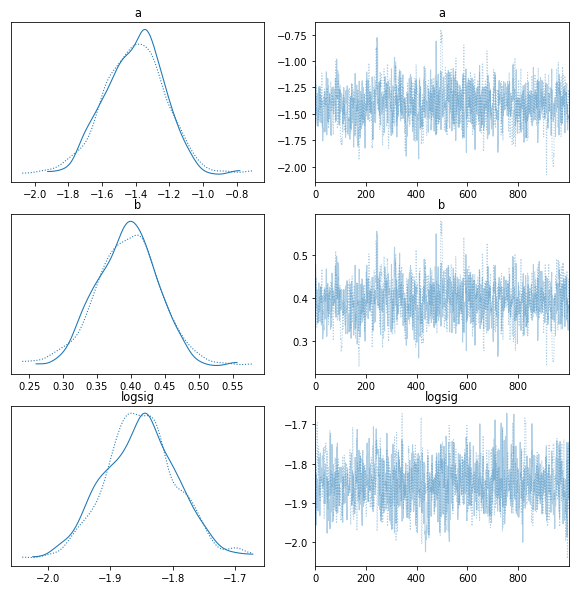

In [46]:
with pm.Model() as model: 
    #uniform priors
    a = pm.Uniform("a", lower = -100, upper = 100)
    b = pm.Uniform("b", lower = -100, upper = 100)
    logsig = pm.Uniform("logsig", lower=-10, upper=10)
    
    
    #log-likelihood function
    pm.Normal("obs", mu = a*np.log10(data[0])+b, sigma = pm.math.exp(logsig) + data[2], observed=data[1])
    
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=2)
    
    _ = pm.traceplot(trace, var_names=["a", "b", "logsig"], figsize = (10,10))
        
    pm.summary(trace, var_names=["a", "b", "logsig"])
    
    

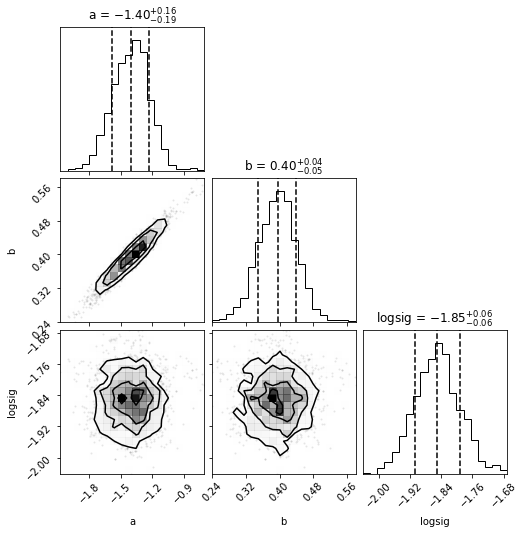

In [47]:
trace
samples = pm.trace_to_dataframe(trace, varnames=["a", "b", "logsig"])
_ = corner.corner(samples, truths=[500, 0, None], quantiles=[.16, .50, .84], show_titles = True)

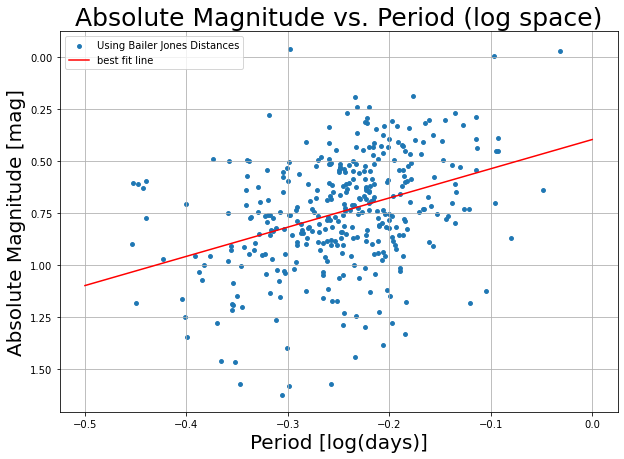

In [48]:
a = np.mean(samples['a'])
b = np.mean(samples['b'])

x = np.linspace(-0.5, 0, 100)
y = a*x + b


plt.figure(figsize = (10,7))
plt.scatter(np.log10(periods), G_band_absolute_magnitudes, s = 15, label = 'Using Bailer Jones Distances')
plt.grid()
plt.xlabel('Period [log(days)]', size = 20)
plt.ylabel('Absolute Magnitude [mag]', size = 20)
plt.title('Absolute Magnitude vs. Period (log space)', size = 25)
plt.gca().invert_yaxis()
plt.plot(x,y, color = 'r', label = 'best fit line')
plt.legend()


## Problem 20 (WISE survey data)

In [49]:
query_f = """SELECT TOP 800
gaia_source.source_id,
gaia_source.parallax,
gaia_source.parallax_over_error,
gaia_source.b,
gaia_source.l,
gaia_source.bp_rp,
gaia_source.phot_bp_mean_flux_error,
gaia_source.phot_rp_mean_flux_error,

SQRT(POWER(2.5/log(10) / phot_bp_mean_flux_over_error, 2) + POWER(2.5/log(10) / phot_rp_mean_flux_over_error, 2)) AS bp_rp_error

vari_rrlyrae.pf,
vari_rrlyrae.pf_error,
vari_rrlyrae.int_average_g,
vari_rrlyrae.int_average_g_error,

gaiaedr3_distance.r_med_geo,
gaiaedr3_distance.r_hi_geo,
gaiaedr3_distance.r_lo_geo

FROM gaiadr3.vari_rrlyrae 
JOIN gaiaedr3.gaia_source USING (source_id)
JOIN external.gaiaedr3_distance USING (source_id)

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 40
AND ABS(gaia_source.b) > 30
AND gaia_source.parallax > 0.25
AND gaia_source.parallax_over_error > 10 

AND gaia_source.astrometric_excess_noise < 1
AND gaia_source.phot_bp_rp_excess_factor < 1.3 + 0.06 * POWER(gaia_source.bp_rp, 2)
AND gaia_source.phot_bp_rp_excess_factor > 1.0 + 0.015 * POWER(gaia_source.bp_rp, 2)
AND vari_rrlyrae.int_average_g - 5 * LOG10(gaiaedr3_distance.r_med_geo) + 5 < 3.5

AND pf IS NOT NULL 


"""

query_wise = """SELECT TOP 800
gaia_source.source_id,
gaia_source.parallax,
gaia_source.parallax_over_error,
gaia_source.b,
gaia_source.l,
gaia_source.bp_rp,
SQRT(POWER(2.5/log(10) / phot_bp_mean_flux_over_error, 2) + POWER(2.5/log(10) / phot_rp_mean_flux_over_error, 2)) AS bp_rp_over_error,

vari_rrlyrae.pf,
vari_rrlyrae.pf_error,
vari_rrlyrae.int_average_g,
vari_rrlyrae.int_average_g_error,

gaiaedr3_distance.r_med_geo,
gaiaedr3_distance.r_hi_geo,
gaiaedr3_distance.r_lo_geo,

allwise_best_neighbour.original_ext_source_id,
allwise_best_neighbour.allwise_oid,

aw.allwise_oid,
aw.w2gmag,
aw.w2mpro,
aw.w2mpro_error

FROM gaiadr3.vari_rrlyrae
INNER JOIN gaiaedr3.allwise_best_neighbour USING (source_id)
JOIN gaiaedr3.gaia_source USING (source_id)
JOIN external.gaiaedr3_distance USING (source_id)

JOIN gaiadr1.allwise_original_valid AS aw ON allwise_best_neighbour.allwise_oid = aw.allwise_oid

WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g >= 40
AND ABS(gaia_source.b) > 30
AND gaia_source.parallax > 0.25
AND gaia_source.parallax_over_error > 10 

AND gaia_source.phot_bp_mean_flux_over_error > 10
AND gaia_source.phot_rp_mean_flux_over_error > 10
AND gaia_source.bp_rp < 0.75

AND gaia_source.astrometric_excess_noise < 1
AND gaia_source.phot_bp_rp_excess_factor < 1.3 + 0.06 * POWER(gaia_source.bp_rp, 2)
AND gaia_source.phot_bp_rp_excess_factor > 1.0 + 0.015 * POWER(gaia_source.bp_rp, 2)
AND vari_rrlyrae.int_average_g - 5 * LOG10(gaiaedr3_distance.r_med_geo) + 5 < 3.5


AND pf IS NOT NULL 

"""

'JOIN external.allwise_original_valid as aw ON allwise_best_neighbour.allwise_oid = aw.allwise_oid'
@memory.cache
def get_gaia_query(q):
    start = TIME.time()
    job = Gaia.launch_job(q)
    print(f"Total time: {TIME.time()-start:0.2f} sec")
    return job.get_results()

df = get_gaia_query(query_wise)
df



<Table length=341>
     source_id            parallax      ...  w2mpro w2mpro_error
                            mas         ...   mag       mag     
       int64              float64       ... float64   float64   
------------------- ------------------- ... ------- ------------
5082275006547809536 0.26809523957285347 ...  12.394        0.024
5083946363004134144  0.5946781130908292 ...  10.936         0.02
5094203642556959744  0.5017024595959433 ...  10.863        0.019
5094426804761045248  0.4086511433886336 ...  11.231        0.021
5098240155900394112 0.36106562106170625 ...  11.405        0.021
 584371601026374272  0.5023216203946383 ...  11.043        0.021
 586254622063844736   0.413362843606383 ...  11.217        0.021
3844396540563624832   0.613325049466868 ...  10.372        0.021
2313783205448950784  0.3701002230002173 ...  11.721        0.022
                ...                 ... ...     ...          ...
4972298520643889536 0.25685346932492525 ...  12.551        0.024
4982010850448460160 0.29846906523214584 ...  12.226        0.022
4984655725669340544 0.37781206603604417 ...   11.57        0.021
4985455998336183168  0.8790500477619054 ...  10.044        0.021
3675137235252376960  0.5023581581779739 ...  11.294        0.021
 632467228922479104  0.2755567391321881 ...  12.041        0.022
 648476397396238976 0.49866765663757956 ...  10.904         0.02
3727833391597367424  0.7722731001961485 ...     9.7        0.019
3731723090075245696  0.5577167596167709 ...  10.503         0.02
3737667393532367616  0.3124025279628002 ...  12.232        0.023

## Problem 21 (mcmc WISE data) **

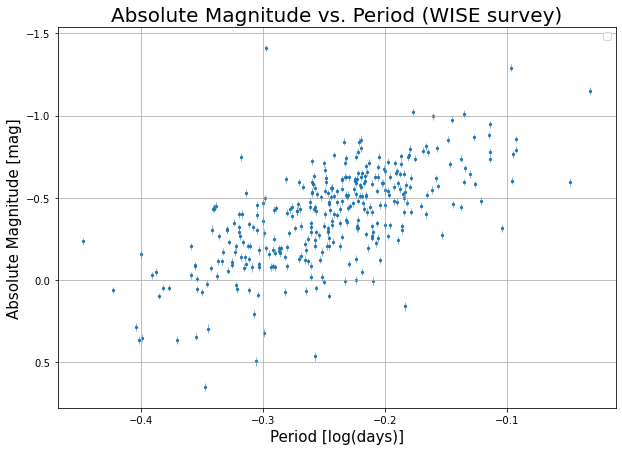

In [50]:
w2mpro = df['w2mpro']
bailer_jones_d = df['r_med_geo']
w2mpro_errors = df['w2mpro_error']
periods = df['pf']

w2mpro_M = w2mpro - 5*np.log10(bailer_jones_d) + 5

plt.figure(figsize = (10,7))
plt.scatter(np.log10(periods), w2mpro_M, s = 5)
plt.errorbar(np.log10(periods), w2mpro_M, yerr = w2mpro_errors, fmt = 'none', elinewidth = 0.5)

plt.legend()
plt.grid()
plt.xlabel('Period [log(days)]', size = 15)
plt.ylabel('Absolute Magnitude [mag]', size = 15)
plt.title('Absolute Magnitude vs. Period (WISE survey)', size = 20)
plt.gca().invert_yaxis()

/srv/conda/envs/notebook/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logsig, b, a]
INFO:pymc3:NUTS: [logsig, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
/tmp/ipykernel_1095/2134446927.py:17: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  _ = pm.traceplot(trace, var_names=["a", "b", "logsig"], figsize = (10,10))


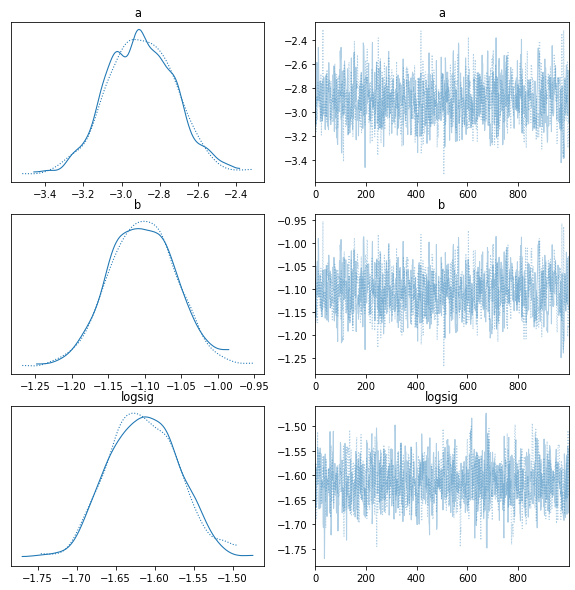

In [51]:
data[0] = periods
data[1] = w2mpro_M
data[2] = w2mpro_errors

with pm.Model() as model: 
    #uniform priors
    a = pm.Uniform("a", lower = -100, upper = 100)
    b = pm.Uniform("b", lower = -100, upper = 100)
    logsig = pm.Uniform("logsig", lower=-10, upper=10)
    
    
    #log-likelihood function
    pm.Normal("obs", mu = a*np.log10(data[0])+b, sigma = pm.math.exp(logsig) + data[2], observed=data[1])
    
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=2)
    
    _ = pm.traceplot(trace, var_names=["a", "b", "logsig"], figsize = (10,10))
        
    pm.summary(trace, var_names=["a", "b", "logsig"])

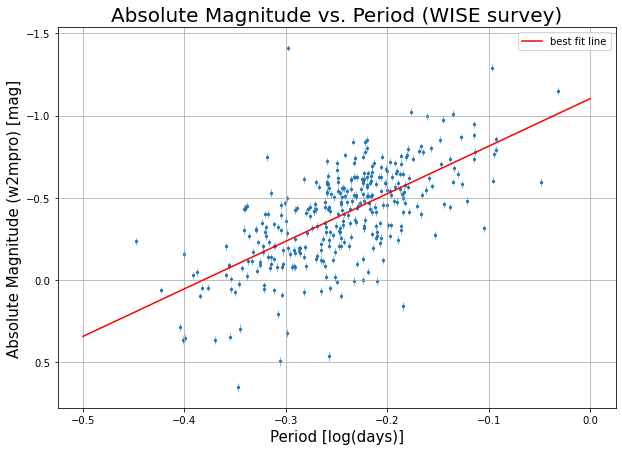

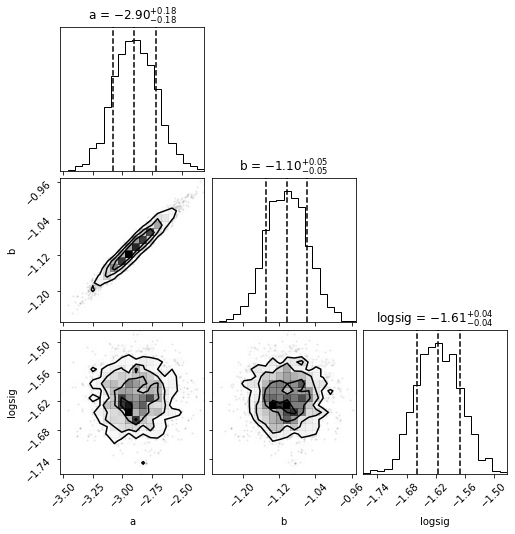

In [52]:
plt.figure(figsize = (10,7))
plt.scatter(np.log10(periods), w2mpro_M, s = 5)
plt.errorbar(np.log10(periods), w2mpro_M, yerr = w2mpro_errors, fmt = 'none', elinewidth = 0.5)

plt.legend()
plt.grid()
plt.xlabel('Period [log(days)]', size = 15)
plt.ylabel('Absolute Magnitude (w2mpro) [mag]', size = 15)
plt.title('Absolute Magnitude vs. Period (WISE survey)', size = 20)
plt.gca().invert_yaxis()

samples = pm.trace_to_dataframe(trace, varnames=["a", "b", "logsig"])

a = np.mean(samples['a'])
b = np.mean(samples['b'])
x = np.linspace(-0.5, 0)
y = a*x + b
plt.plot(x,y, label = 'best fit line', color = 'r')
plt.legend()

_ = corner.corner(samples, truths=[500, 0, None], quantiles=[.16, .50, .84], show_titles = True)

## Problem 22 (comments)

The W2 measurements have a lower magnitude than the G bands of the gaia data. The period-luminosity relationship is steeper with the W2 magnitudes

## Problem 23 (comparison to literature)

The slope reported Beaton et al. 2018 from W2 mag (-2.54) is quite comparable with the slope obtained from the mcmc sampler . V band has no PL slope?

## Problem 24 (log period vs bp-rp) **

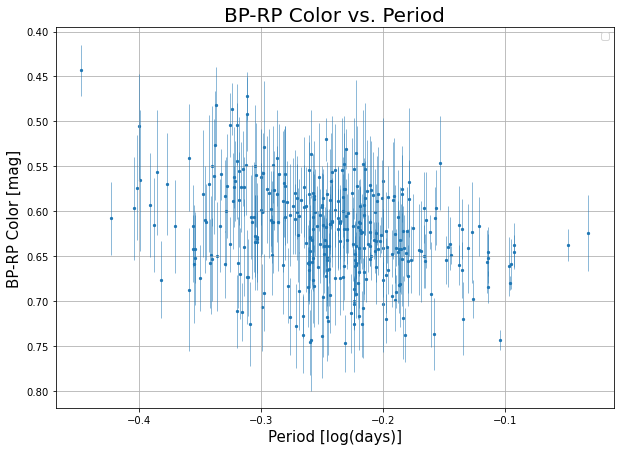

In [53]:
bp_rp = df['bp_rp']
bailer_jones_d = df['r_med_geo']
bp_rp_errors = df['bp_rp_over_error']

w2mpro_M = w2mpro - 5*np.log10(bailer_jones_d) + 5

plt.figure(figsize = (10,7))
plt.scatter(np.log10(periods), bp_rp, s = 5)
plt.errorbar(np.log10(periods), bp_rp, yerr = bp_rp_errors, fmt = 'none', elinewidth = 0.5)

plt.legend()
plt.grid()
plt.xlabel('Period [log(days)]', size = 15)
plt.ylabel('BP-RP Color [mag]', size = 15)
plt.title('BP-RP Color vs. Period', size = 20)
plt.gca().invert_yaxis()

/srv/conda/envs/notebook/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logsig, b, a]
INFO:pymc3:NUTS: [logsig, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
/tmp/ipykernel_1095/1528197611.py:17: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  _ = pm.traceplot(trace, var_names=["a", "b", "logsig"], figsize = (10,10))


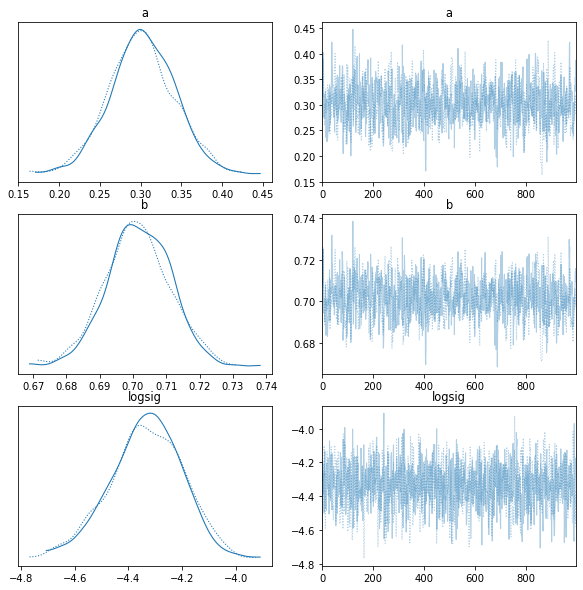

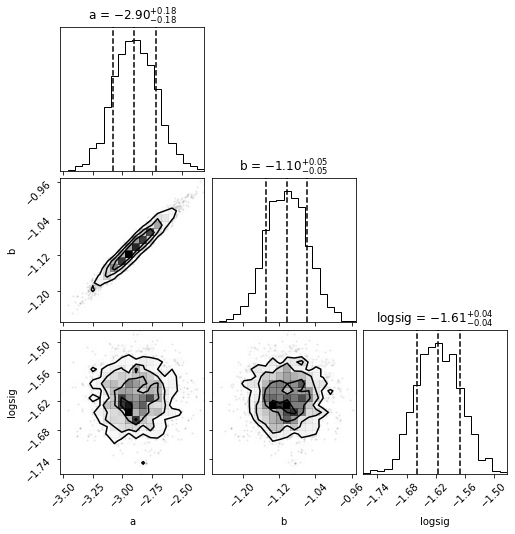

In [54]:
data[0] = periods
data[1] = bp_rp
data[2] = bp_rp_errors

with pm.Model() as model: 
    #uniform priors
    a = pm.Uniform("a", lower = -100, upper = 100)
    b = pm.Uniform("b", lower = -100, upper = 100)
    logsig = pm.Uniform("logsig", lower=-10, upper=10)
    
    
    #log-likelihood function
    pm.Normal("obs", mu = a*np.log10(data[0])+b, sigma = pm.math.exp(logsig) + data[2], observed=data[1])
    
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=2)
    
    _ = pm.traceplot(trace, var_names=["a", "b", "logsig"], figsize = (10,10))
        
    pm.summary(trace, var_names=["a", "b", "logsig"])
    
_ = corner.corner(samples, truths=[500, 0, None], quantiles=[.16, .50, .84], show_titles = True)

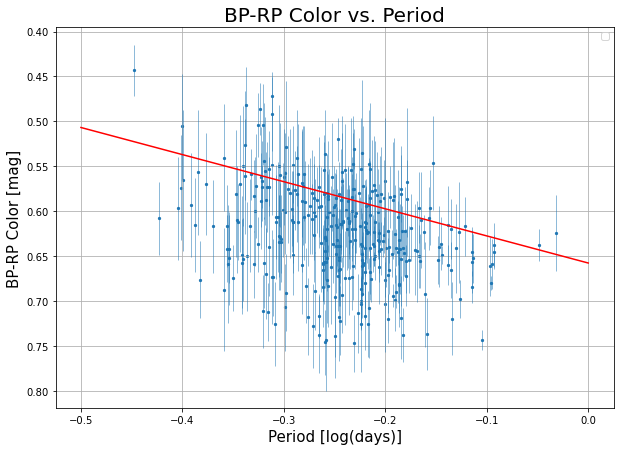

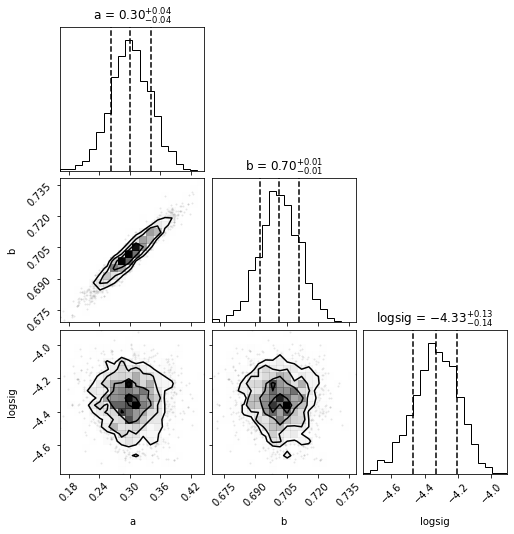

In [55]:
plt.figure(figsize = (10,7))
plt.scatter(np.log10(periods), bp_rp, s = 5)
plt.errorbar(np.log10(periods), bp_rp, yerr = bp_rp_errors, fmt = 'none', elinewidth = 0.5)

plt.legend()
plt.grid()
plt.xlabel('Period [log(days)]', size = 15)
plt.ylabel('BP-RP Color [mag]', size = 15)
plt.title('BP-RP Color vs. Period', size = 20)
plt.gca().invert_yaxis()


samples = pm.trace_to_dataframe(trace, varnames=["a", "b", "logsig"])


#FITTING PARAMETERS
a = np.mean(samples['a'])
b = np.mean(samples['b']) - np.mean(bp_rp_errors)
x = np.linspace(-0.5, 0)
y = a*x + b
plt.plot(x,y, color = 'r', label = 'best fit line')

_ = corner.corner(samples, truths=[500, 0, None], quantiles=[.16, .50, .84], show_titles = True)


## Problem 25

In [56]:
query_f = """SELECT TOP 120000

gaia_source.source_id,
gaia_source.parallax,
gaia_source.parallax_over_error,
gaia_source.b,
gaia_source.l,
gaia_source.bp_rp,
gaia_source.phot_bp_mean_flux_error,
gaia_source.phot_rp_mean_flux_error,
gaia_source.phot_g_mean_mag,


vari_rrlyrae.pf,
vari_rrlyrae.pf_error,
vari_rrlyrae.int_average_g,
vari_rrlyrae.int_average_g_error,
vari_rrlyrae.G_absorption,

gaiaedr3_distance.r_med_geo,
gaiaedr3_distance.r_hi_geo,
gaiaedr3_distance.r_lo_geo

FROM gaiadr3.vari_rrlyrae 
JOIN gaiaedr3.gaia_source USING (source_id)
JOIN external.gaiaedr3_distance USING (source_id)

WHERE pf IS NOT NULL 
AND gaia_source.parallax > 0

AND gaia_source.astrometric_excess_noise < 5
AND gaia_source.phot_bp_rp_excess_factor < 3 + 0.06 * POWER(gaia_source.bp_rp, 2)
AND gaia_source.phot_bp_rp_excess_factor > 0.3 + 0.015 * POWER(gaia_source.bp_rp, 2)
AND vari_rrlyrae.int_average_g - 5 * LOG10(gaiaedr3_distance.r_med_geo) + 5 < 6


AND bp_rp IS NOT NULL


"""
'SQRT(POWER(2.5/log(10) / phot_bp_mean_flux_over_error, 2) + POWER(2.5/log(10) / phot_rp_mean_flux_over_error, 2)) AS bp_rp_over_error,'

@memory.cache
def get_gaia_query(q):
    start = TIME.time()
    job = Gaia.launch_job(q)
    print(f"Total time: {TIME.time()-start:0.2f} sec")
    return job.get_results()

df = get_gaia_query(query_f)
df

<Table length=80813>
     source_id            parallax       ...  r_hi_geo  r_lo_geo
                            mas          ...     pc        pc   
       int64              float64        ...  float32   float32 
------------------- -------------------- ... --------- ---------
 245002531050576896  0.05853790153772867 ...  8547.597  5657.442
 245504251951140864  0.23173543212392547 ...  4740.336 2567.3264
 246756973652292992   0.8320906250015189 ... 1216.2039  1166.377
 358320600290537600 0.012214200887114463 ...  10730.45 5565.4937
 358693648267575424  0.36220112340216243 ... 2648.0107 2429.7112
 359282333664874624  0.07216627373387281 ...   6736.49 4057.5225
3352538913055092736  0.24596110921903885 ... 3869.0376  3071.185
3352972120634784128  0.12874859622288895 ... 6491.7026 4611.8833
3353087255820902528   0.1343611674591948 ...  6373.157  4053.471
                ...                  ... ...       ...       ...
5917180090153787264  0.08933418807034825 ...  9939.945   5892.23
5917181979939459840  0.07749170068478389 ... 11256.721  6273.657
5917187782413199872  0.10199468867459145 ...  9722.289 5747.8003
5917201874228451456  0.07291298751167655 ...  9874.929  6652.018
5917263756119495296 0.003451754861123646 ... 11708.488  6775.287
5917316326520943104  0.04432332670267133 ... 11427.368  6234.937
5917327905724679808   1.1933288015863739 ... 13446.973 3418.2327
5917338213674988800  0.10704958101533889 ...  8362.071 4959.3174
5917397415506362496  0.05454719510568818 ... 11323.751 7148.5176
5917421845281955584   0.1399974493634684 ...   6947.68  4591.605

## Problem 26 (calculate color excess and A_G)

In [57]:
#calculate absolute magnitudes 
bailer_jones_d = df['r_med_geo']
phot_g_mean_mags = df['phot_g_mean_mag']

M = phot_g_mean_mags - 5*np.log10(bailer_jones_d) + 5

bp_rp_observed = df['bp_rp']

periods = df['pf']

bp_rp_intrinsic = a*np.log10(periods) + b 

color_excess = bp_rp_observed - bp_rp_intrinsic

A_G = 2 * color_excess


## Problem 27 (compare A_G with G absorption in rrlyrae catalog)

0.08107105084821949

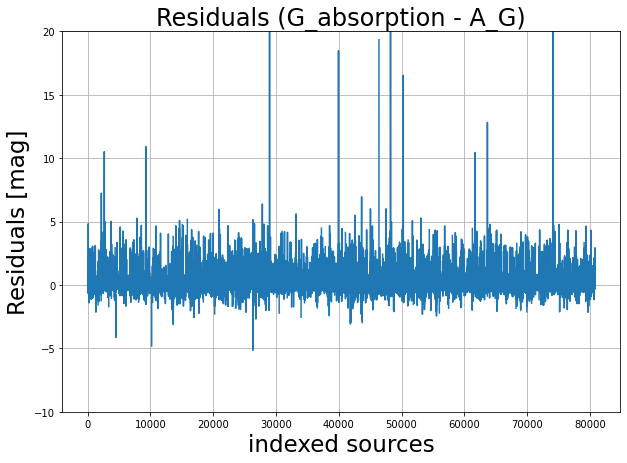

In [63]:

G_absorptions = df['g_absorption']

plt.figure(figsize = (10,7))
plt.grid()
residuals = G_absorptions - A_G
x = np.linspace(0, len(residuals), len(residuals))
plt.plot(x,residuals)
plt.title('Residuals (G_absorption - A_G)', size = 24)
plt.ylabel('Residuals [mag]', size = 23)
plt.xlabel('indexed sources', size = 23)
plt.ylim(-10,20)

np.mean(residuals)


## Problem 28 (2d map)

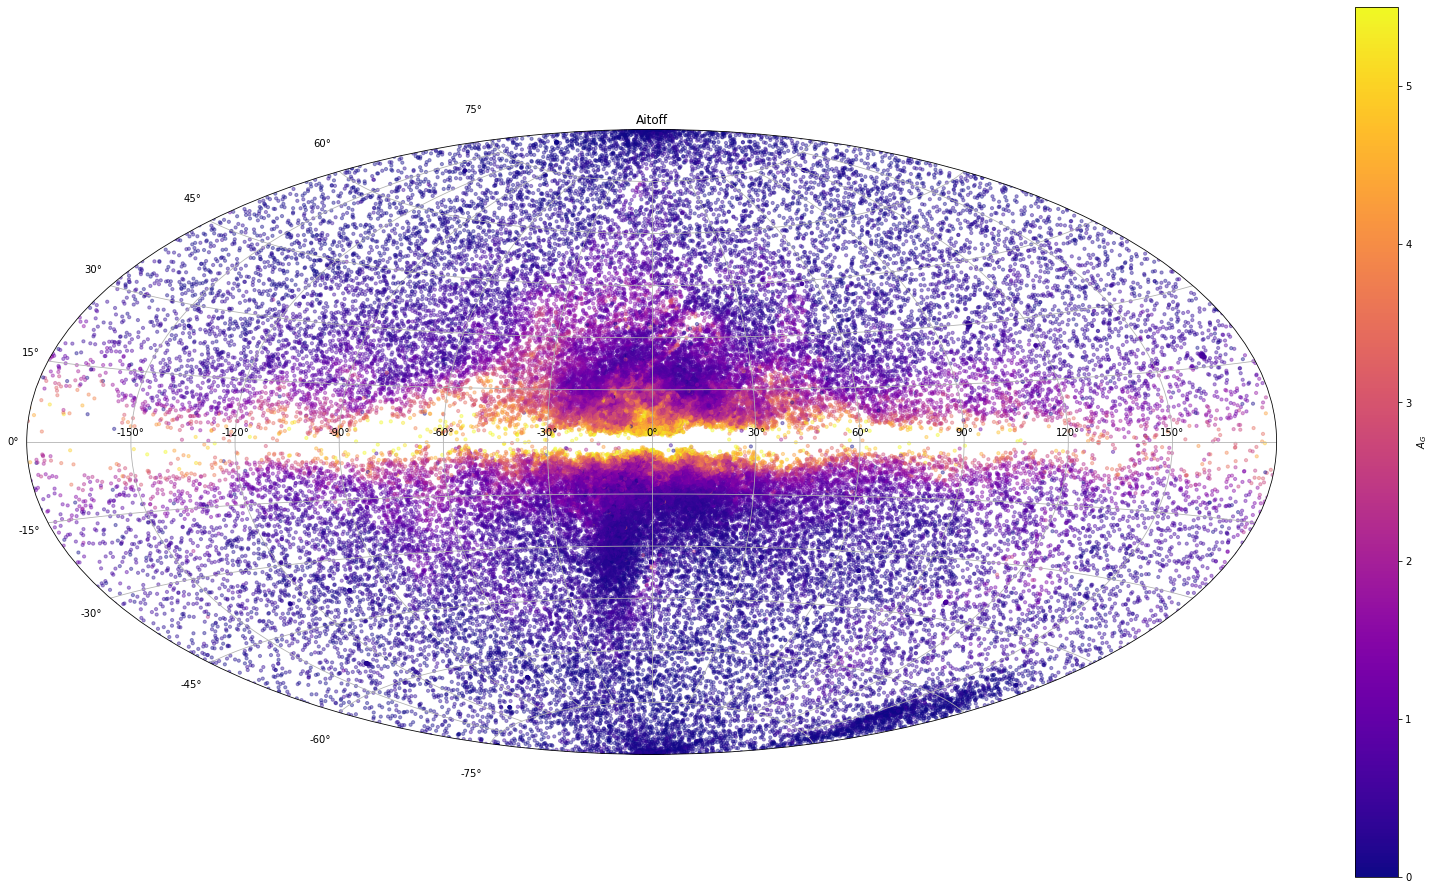

In [59]:
import matplotlib

bs = df['b']
ls = df['l']

bs = bs*2*np.pi/180
ls = -ls*2*np.pi/180

plt.figure(figsize = (28, 16))
plt.subplot(111, projection="aitoff")
plt.title("Aitoff")
plt.grid(True)

norm = matplotlib.colors.Normalize(vmin = 0, vmax = 5.5)
cmap = plt.cm.plasma



plt.scatter(ls,bs, s = 10, c = cmap(norm(A_G)), alpha = 0.4)
plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), label = '$A_G$')



## Problem 29  Schlegel, Finkbeiner, and Davis 1998.

https://arxiv.org/pdf/astro-ph/9710327.pdf

In [60]:
#dustmaps python package
from dustmaps.config import config
config['data_dir'] = '~/somework'

import dustmaps.sfd
dustmaps.sfd.fetch()


Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [61]:
import astropy.units as units
from astropy.coordinates import SkyCoord

from dustmaps.sfd import SFDQuery


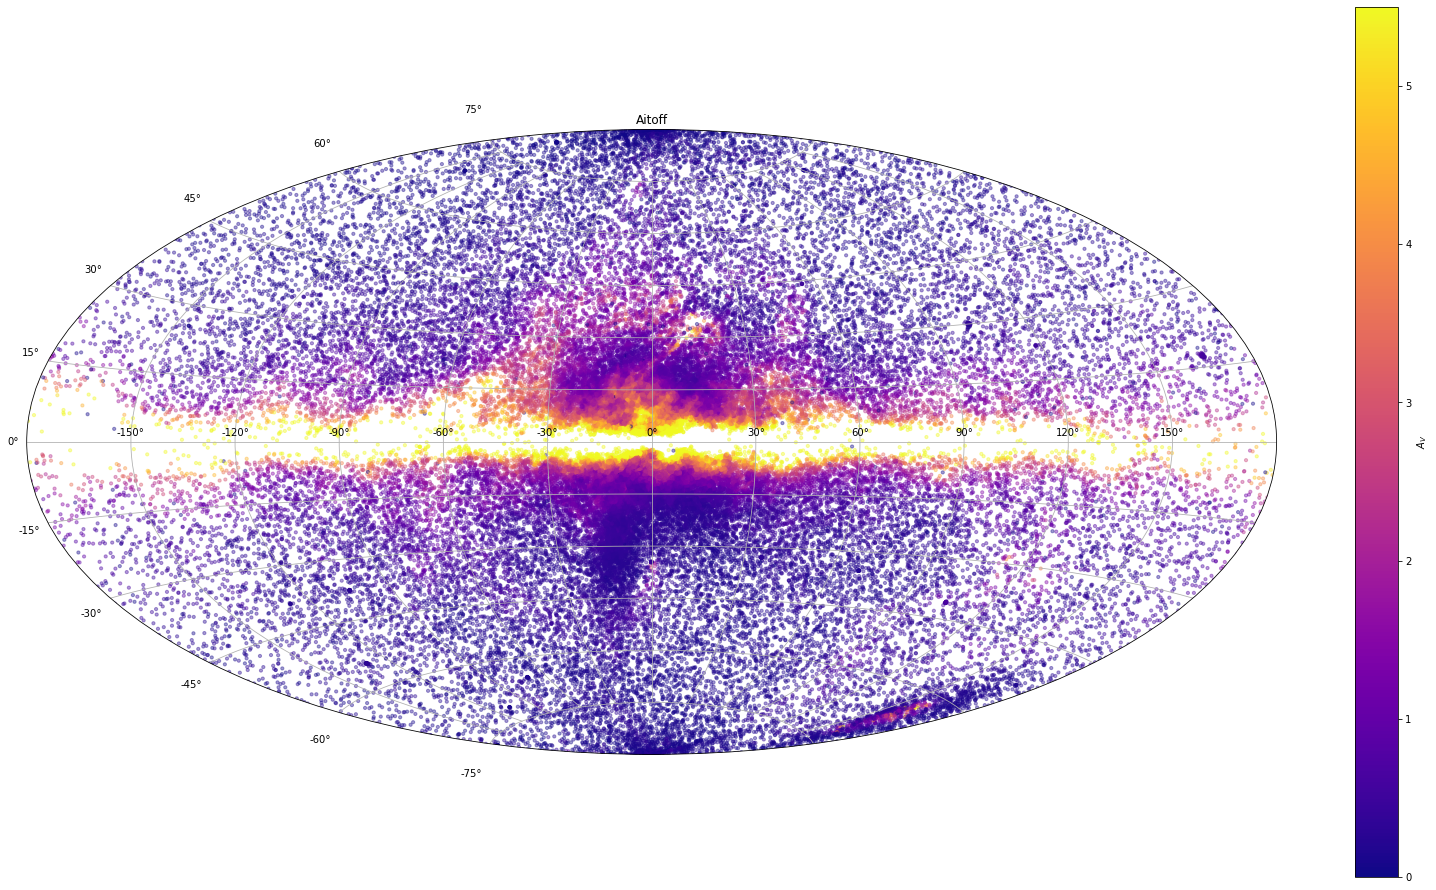

In [62]:
sfd = SFDQuery()


l = df['l']
b = df['b']




coords = SkyCoord(l, b, unit="deg", frame='galactic')
color_excess = sfd(coords)
A_V = 2.742 * sfd(coords)


plt.figure(figsize = (28, 16))
plt.subplot(111, projection="aitoff")
plt.title("Aitoff")
plt.grid(True)

norm = matplotlib.colors.Normalize(vmin = 0, vmax = 5.5)
cmap = plt.cm.plasma



plt.scatter(ls,bs, s = 10, c = cmap(norm(A_V)), alpha = 0.4)
plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), label = '$A_V$')

